In [254]:
import pandas as pd
import csv
import sys
import re
import numpy
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BrainSpan ExonExp

In [238]:
bp_exon_col_meta = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")
bp_exon_col_meta.age.unique()
bp_exon_col_meta["Period"] = bp_exon_col_meta.apply(lambda row: TemporalMap(row["age"])[0], axis=1)
bp_exon_col_meta["Stage"] = bp_exon_col_meta.apply(lambda row: TemporalMap(row["age"])[1], axis=1)
bp_exon_col_meta["Description"] = bp_exon_col_meta.apply(lambda row: TemporalMap(row["age"])[2], axis=1)
print bp_exon_col_meta.shape
bp_exon_col_meta.head(2)

(524, 11)


column_num  donor_id   donor_name    age gender  structure_id  \
0           1     13058  H376.IIA.51  8 pcw      M         10665   
1           2     13058  H376.IIA.51  8 pcw      M         10194   

  structure_acronym               structure_name Period Stage     Description  
0               URL  upper (rostral) rhombic lip     2A     2  Early prenatal  
1               OFC       orbital frontal cortex     2A     2  Early prenatal

In [3]:
print "Sample size", pd.unique(bp_exon_col_meta.donor_id).size
print "Periods:",bp_exon_col_meta.drop_duplicates("donor_id").groupby("Period")["Period"].count()
strcture_count = bp_exon_col_meta.groupby("structure_acronym")["structure_acronym"].count()
Regions = bp_exon_col_meta.drop_duplicates("structure_acronym")[["structure_id","structure_acronym","structure_name"]]
Regions["sample count"] = Regions.apply(lambda row: strcture_count[row["structure_acronym"]], axis=1)
Regions.to_excel("../data/expression/brainspan/exons_matrix/Regions.xlsx", index=False)

Sample size 42
Periods: Period
10    3
11    7
2A    2
2B    3
3A    3
3B    4
4     3
5     5
6     3
7     1
8     5
9     3
Name: Period, dtype: int64


In [212]:
MAGeneCol = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/genes_microarray/columns_metadata.csv")
MAsamples = set(MAGeneCol["donor_id"])
RNAsamples = set(bp_exon_col_meta["donor_id"])
print MAsamples.difference(RNAsamples)
print RNAsamples.difference(MAsamples)

set([])
set([12832, 12289, 263195015, 12295, 12981, 12889, 12890])


In [5]:
bp_exon_row_meta = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
bp_exon_row_meta.head(2)

row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id     start  \
0        1  1086864  ENSG00000000003      TSPAN6     7105.0  99883666   
1        2  1086864  ENSG00000000003      TSPAN6     7105.0  99885755   

        end  exon length  
0  99884983         1317  
1  99885863          108

In [6]:
ExonExp = pd.read_csv("../data/expression/brainspan/exons_matrix/expression_matrix.csv", header=None)
ExonExp.head(2)

0          1          2          3          4          5          6    \
0    1  13.636583  40.862901  32.178981  27.939465  29.324584  23.885710   
1    2  31.731240  86.587706  60.131360  57.718046  58.326412  54.090394   

         7          8          9      ...          515       516       517  \
0  24.887880  16.432391  45.570680    ...     4.347437  4.101772  2.987192   
1  50.138146  35.408905  94.937737    ...     6.332389  5.479924  5.946744   

        518       519       520       521       522       523       524  
0  3.862508  3.362597  2.566516  3.049593  5.025746  1.893471  8.942586  
1  6.017439  5.585987  3.870925  4.083335  7.451925  2.946266  3.868906  

[2 rows x 525 columns]

In [7]:
NormExonExp = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/NormedExonExpMatrix.csv",
                         header = None)
NormExonExp.head(2)

0        1         2         3         4         5         6         7    \
0    1  0.92888  0.994602  1.163014  1.058665  0.973158  1.077006  1.026251   
1    2  2.16143  2.107543  2.173270  2.187017  1.935605  2.438935  2.067446   

        8         9      ...          515       516       517       518  \
0  0.991086  1.055019    ...     1.260625  1.330526  1.289509  1.307571   
1  2.135616  2.197930    ...     1.836202  1.777569  2.567087  2.037077   

        519       520       521       522       523       524  
0  1.108135  1.232750  1.339092  1.442238  1.217121  1.856548  
1  1.840848  1.859284  1.793013  2.138479  1.893857  0.803214  

[2 rows x 525 columns]

In [223]:
GeneExp = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/expression_matrix.csv", header=None)
GeneRow = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/rows_metadata.csv")
GeneCol = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/columns_metadata.csv")
GeneCol["Period"] = GeneCol.apply(lambda row: TemporalMap(row["age"])[0], axis=1)
GeneCol["Stage"] = GeneCol.apply(lambda row: TemporalMap(row["age"])[1], axis=1)
GeneCol["Description"] = GeneCol.apply(lambda row: TemporalMap(row["age"])[2], axis=1)
GeneDat = [GeneExp, GeneRow, GeneCol]

In [270]:
Regionsgt20 = ['OFC', 'VFC', 'HIP', 'ITC', 'AMY', 'DFC', 'STC', 'MFC', 'STR', 'IPC', 
            'V1C', 'S1C', 'A1C', 'M1C', 'CBC', 'MD']
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]

# De novo DB variants

In [9]:
Coding = ["coding", "coding-near-splice", "coding-unknown", "codingComplex","codingComplex-near-splice",
          "frameshift", "frameshift-near-splice", "missense", "missense-near-splice",
          "non-coding-exon", "non-coding-exon-near-splice", "splice-acceptor", "splice-donor",
          "start-lost", "stop-gained", "stop-gained-near-splice", "stop-lost"]
nonssc = pd.read_csv("../data/DenovoVariants/denovo-db.non-ssc-samples.variants.tsv", delimiter="\t", header=1)
ExonicAutsimNonSSC = nonssc[(nonssc["PrimaryPhenotype"]=="autism") & (nonssc["FunctionClass"].isin(Coding))]
ExonicAutsimNonSSC.head()
ssc = pd.read_csv("../data/DenovoVariants/denovo-db.ssc-samples.variants.tsv", delimiter="\t", header=1)
ExonicAutismSSC = ssc[(ssc["PrimaryPhenotype"]=="autism") & (ssc["FunctionClass"].isin(Coding))]
ExonicAutismSSC.head()
df = pd.concat([ExonicAutsimNonSSC, ExonicAutismSSC])
df.to_csv("../data/DenovoVariants/ALL.Autism.Coding.csv", index=False)

# Anlysis

In [10]:
AutismVars = pd.read_csv("../data/DenovoVariants/ALL.Autism.Coding.csv")
AutismVars = AutismVars.drop_duplicates(["#SampleID","Chr","Position"])
AutismVars = AutismVars[ (AutismVars["CaddScore"]>15) | (AutismVars["CaddScore"]==-1)]
GeneCount = AutismVars.groupby("Gene")["Gene"].count()
AutismVars.insert(list(df.columns.values).index("Gene")+1, "GeneCount", AutismVars.apply
                 (lambda row: GeneCount[row["Gene"]], axis=1), allow_duplicates=False )
AutismVars = AutismVars.sort_values(['GeneCount', 'Gene'], ascending=[0, 0])
AutismVars.to_csv("../data/DenovoVariants/tmp.csv", index=False)

In [12]:
bp_exon_row_meta[bp_exon_row_meta["gene_symbol"]=="CHD8"].tail(2)

row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id     start  \
40617    40618  1089281  ENSG00000100888        CHD8    57680.0  21923107   
40618    40619  1089281  ENSG00000100888        CHD8    57680.0  21924190   

            end  exon length  
40617  21923302          195  
40618  21924285           95

/Users/jiayao/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


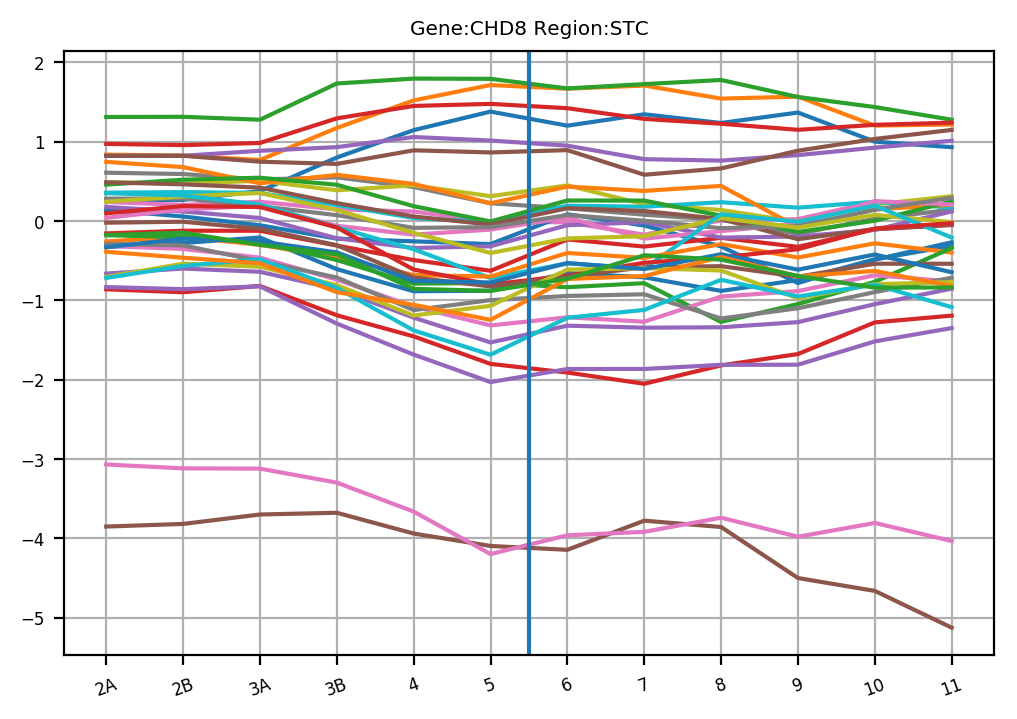

In [15]:
Look("CHD8", "STC", bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

plotting....

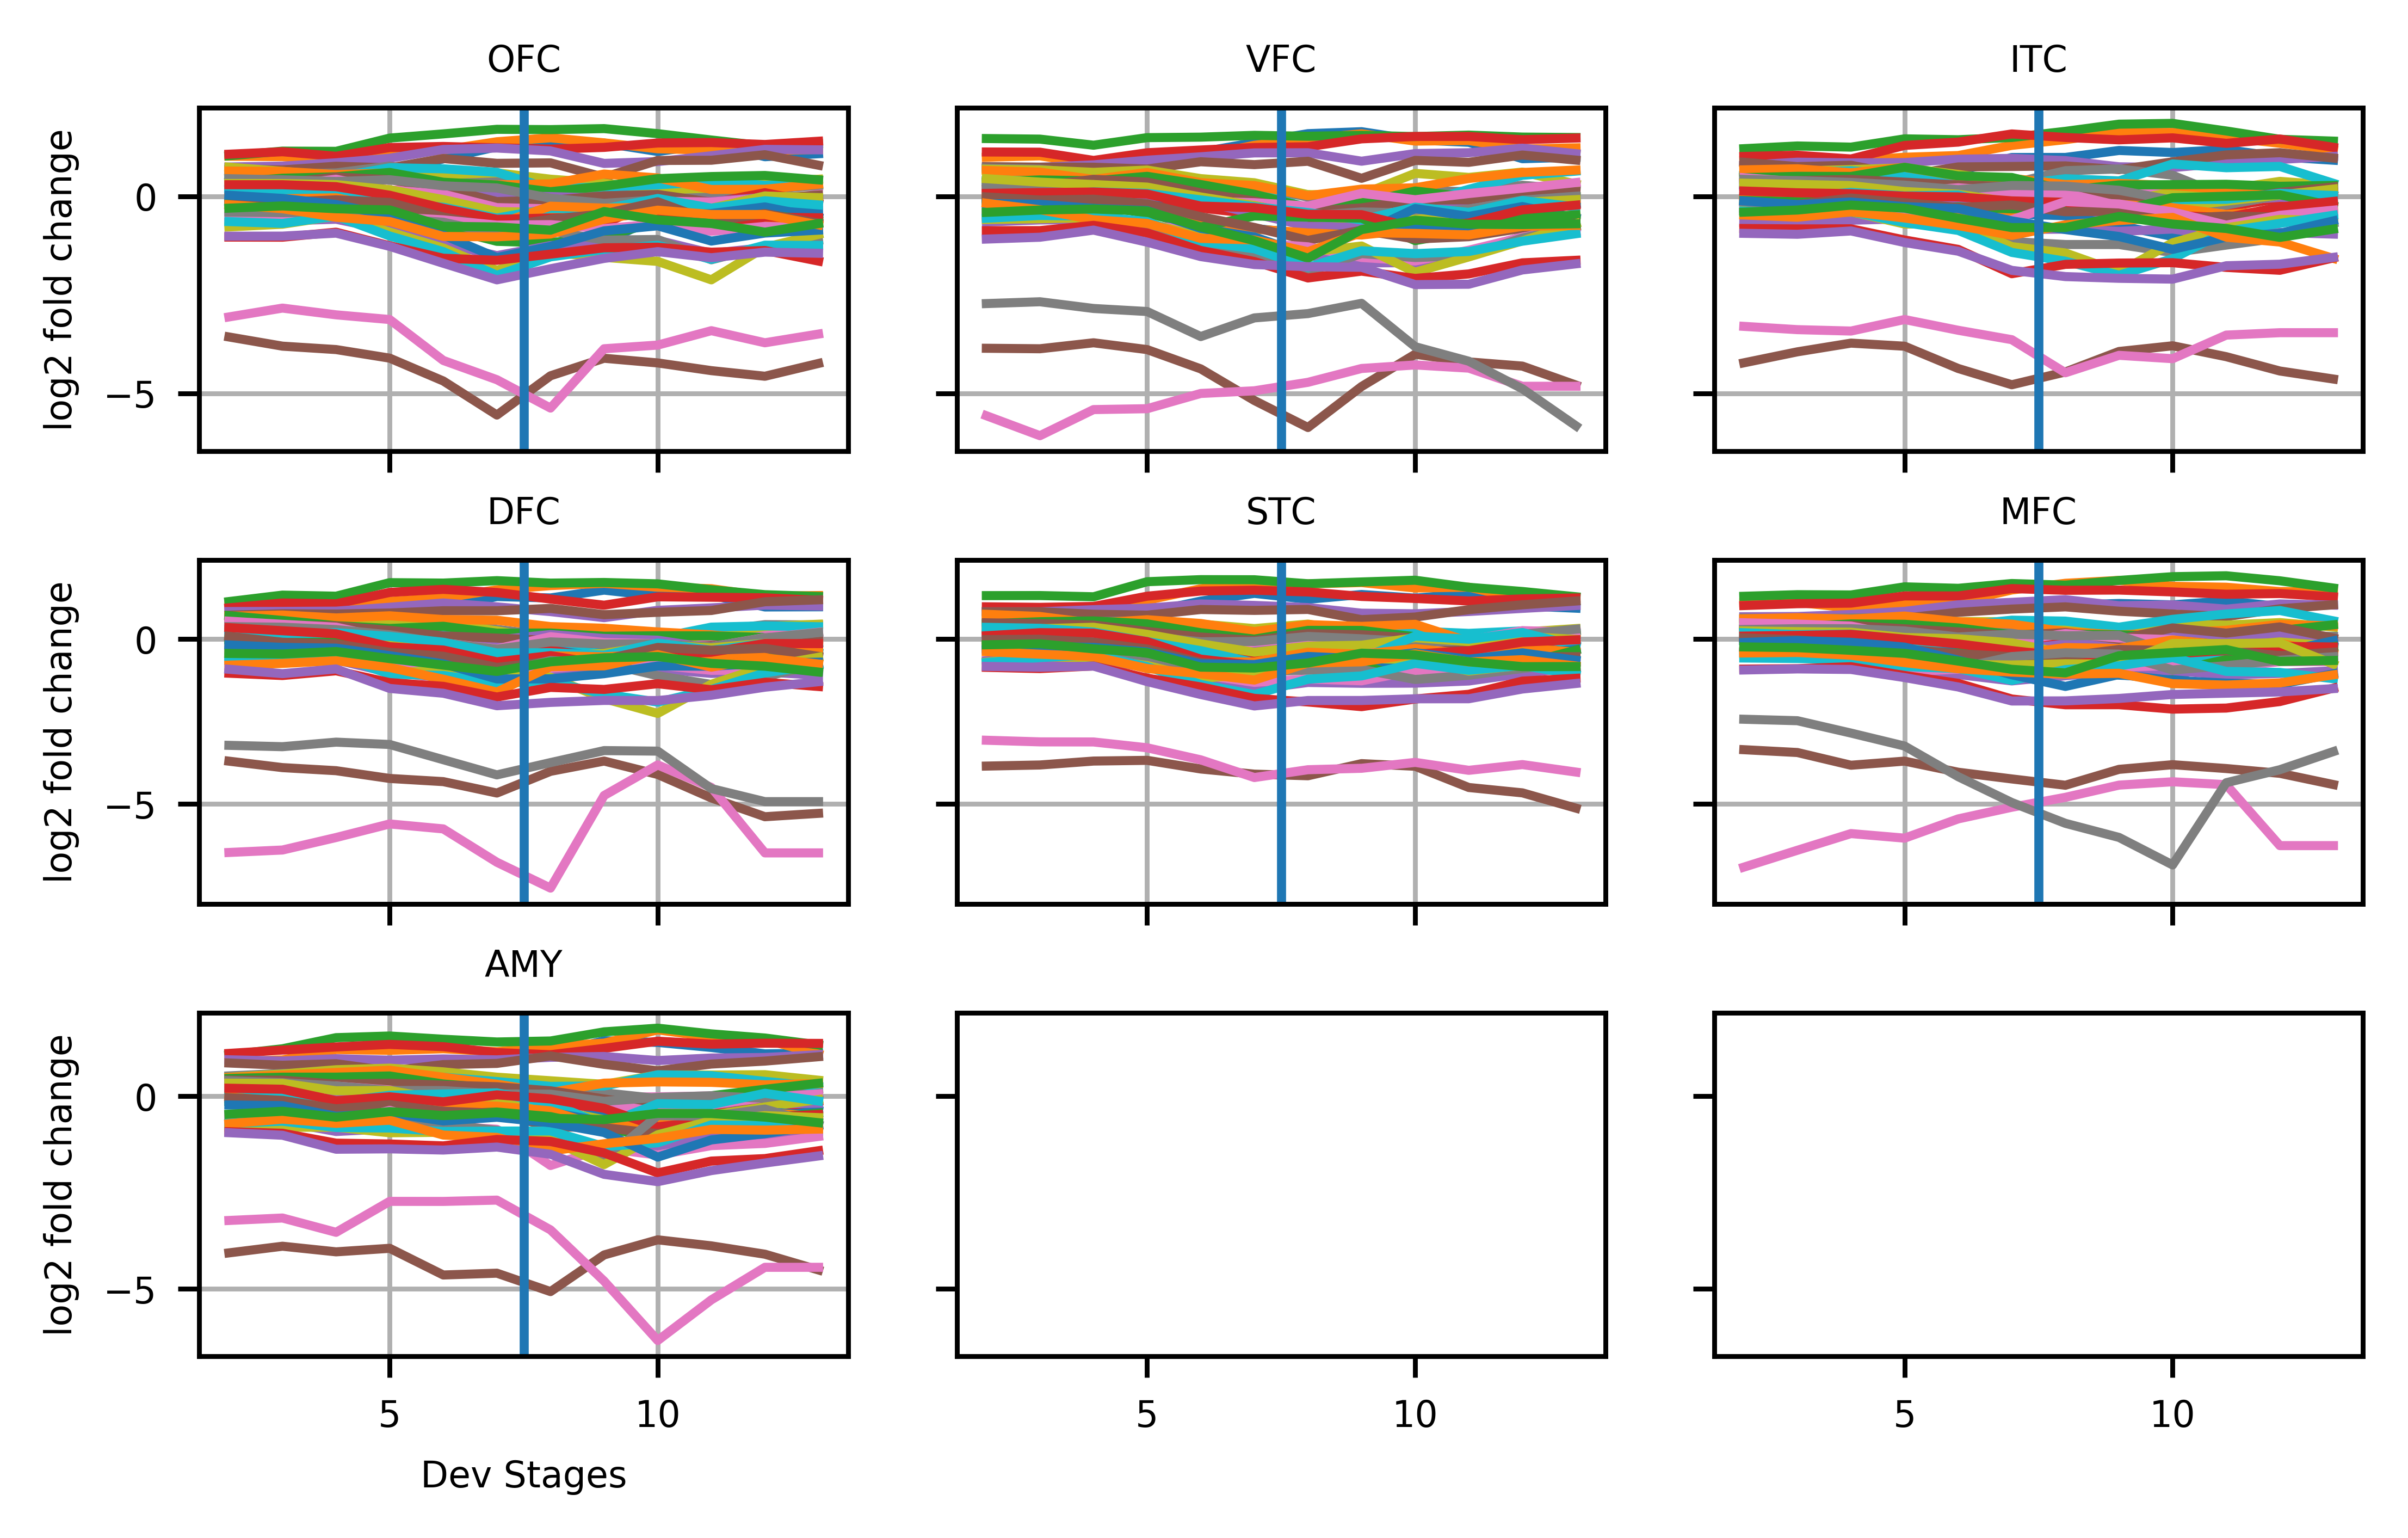

In [25]:
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC", "AMY"]
LookGrid("CHD8", Regions, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

16Three 0 data at stage 1
plotting....

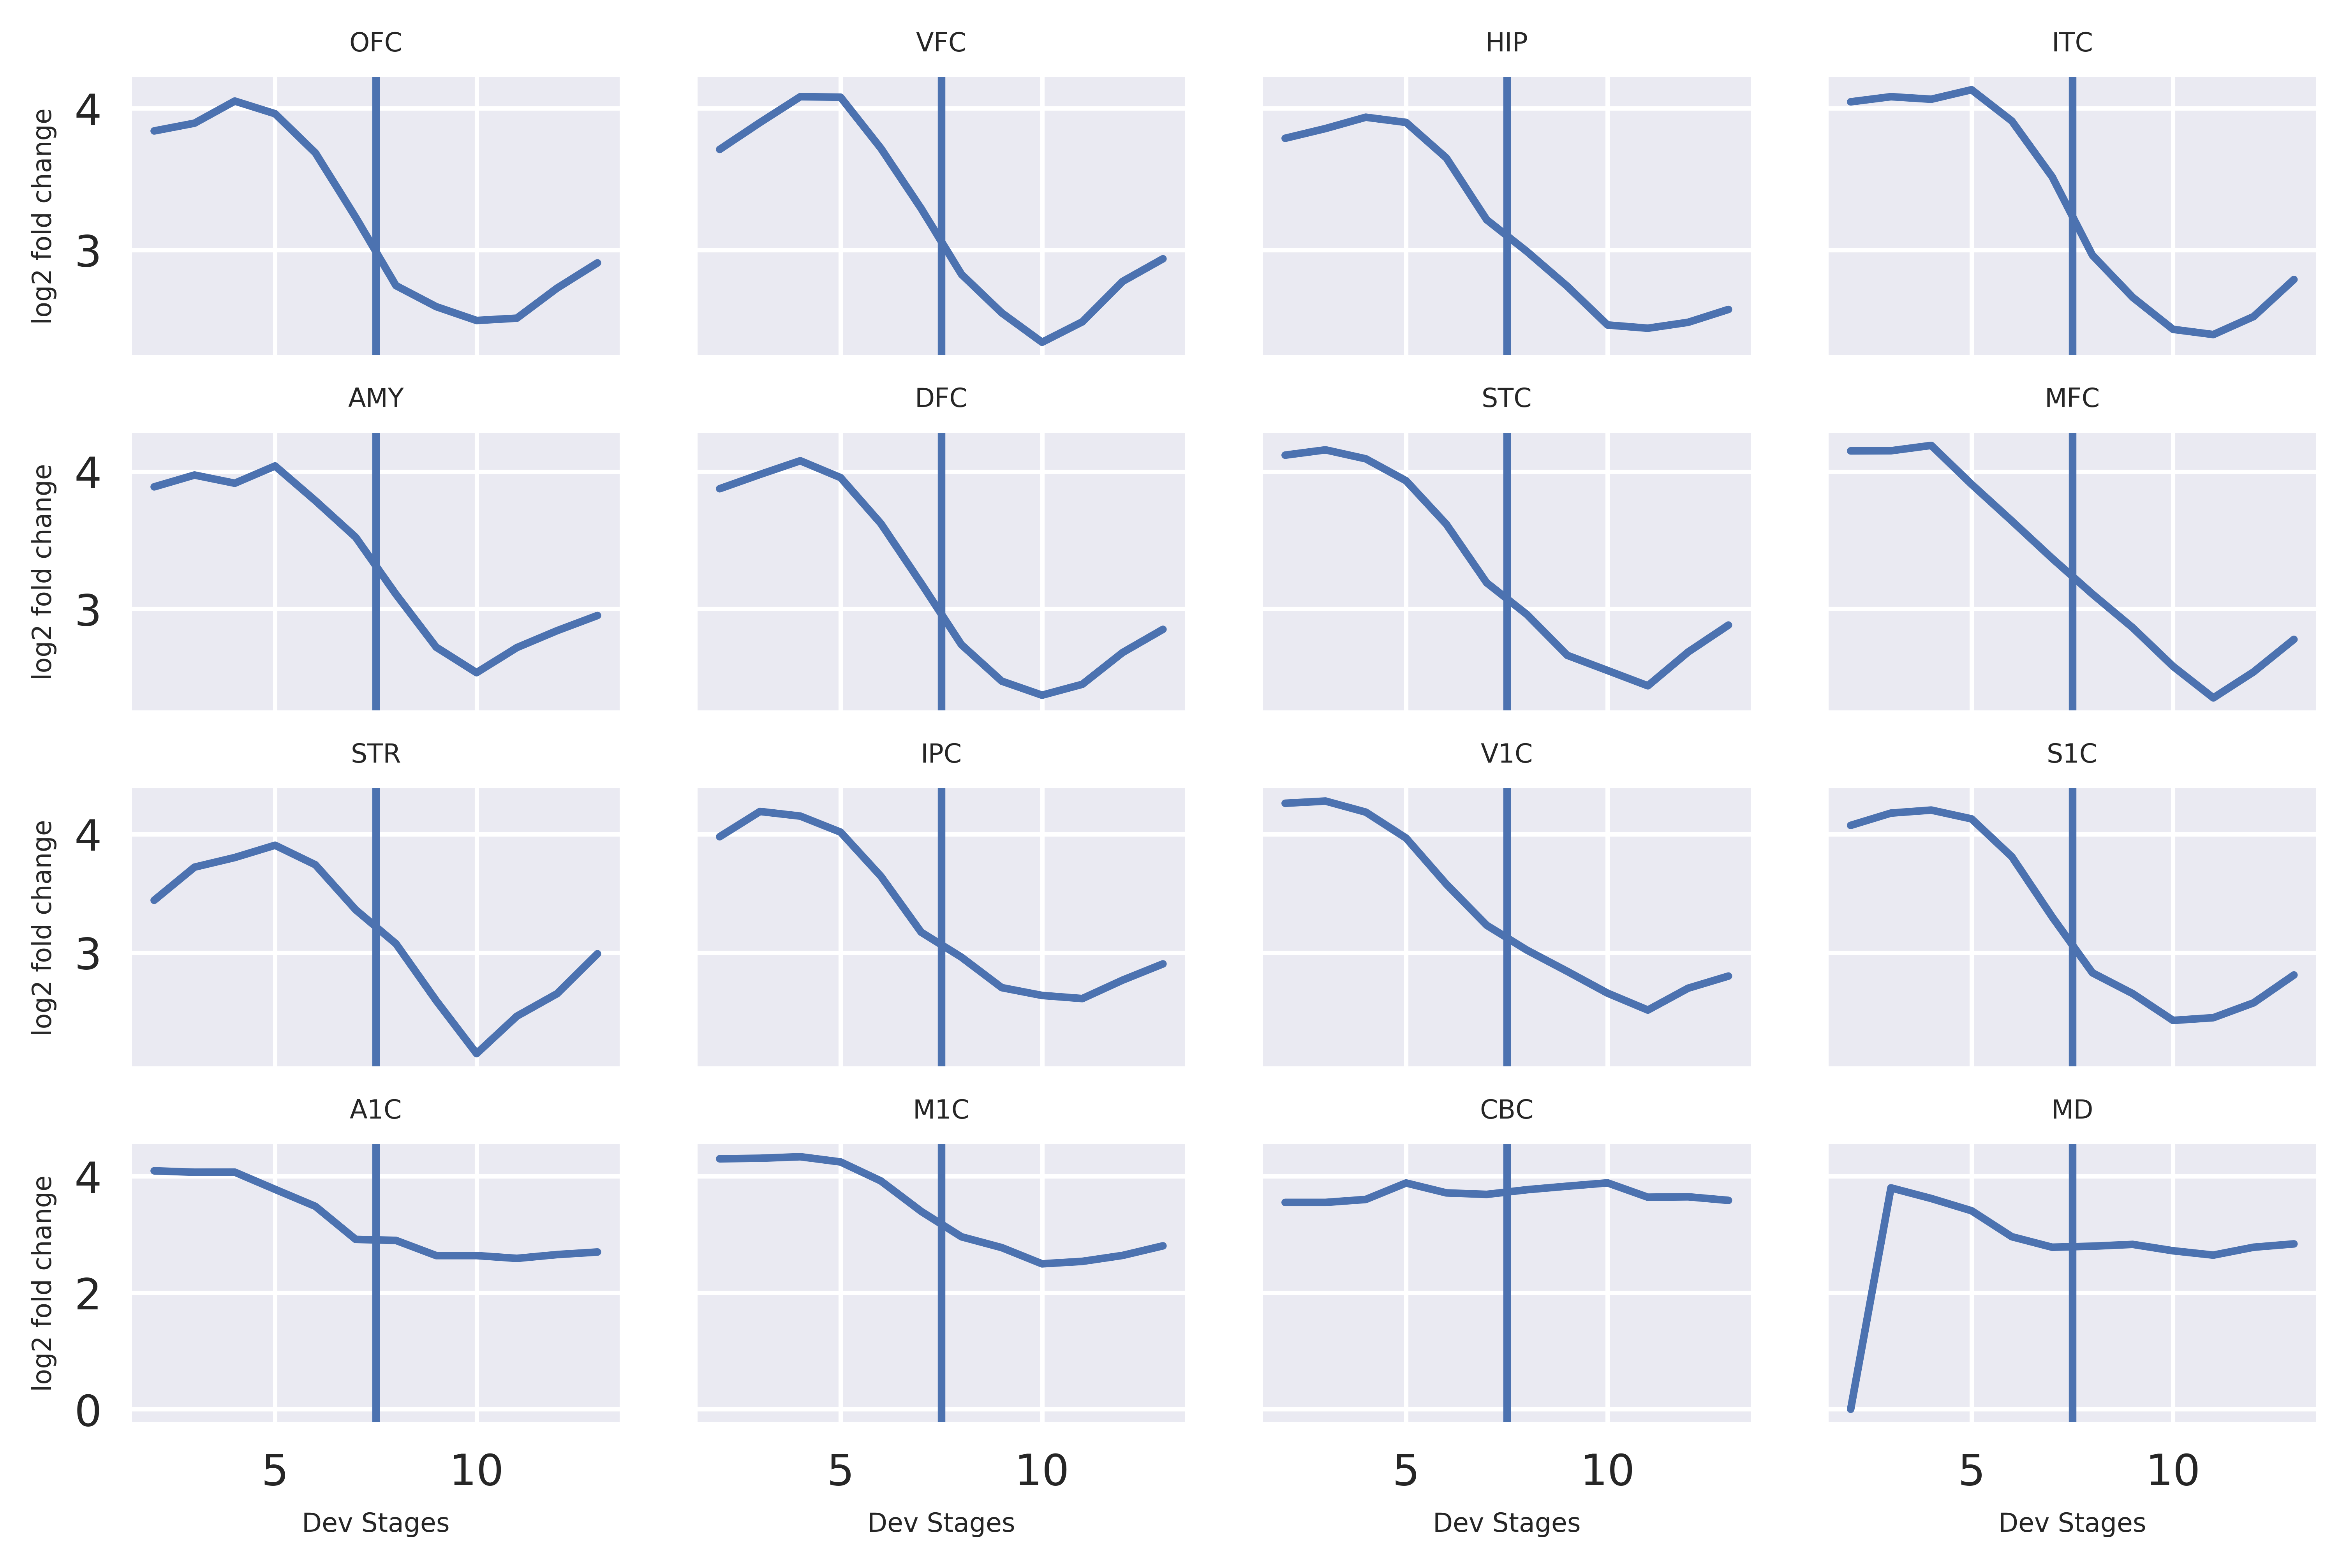

In [142]:
#Look2("DYRK1A", "OFC", GeneRow, GeneCol, GeneExp)
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC", "AMY"]
#Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]
LookGrid("CHD8", Regionsgt20, GeneRow, GeneCol, GeneExp, smooth=True)

16Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
plotting....

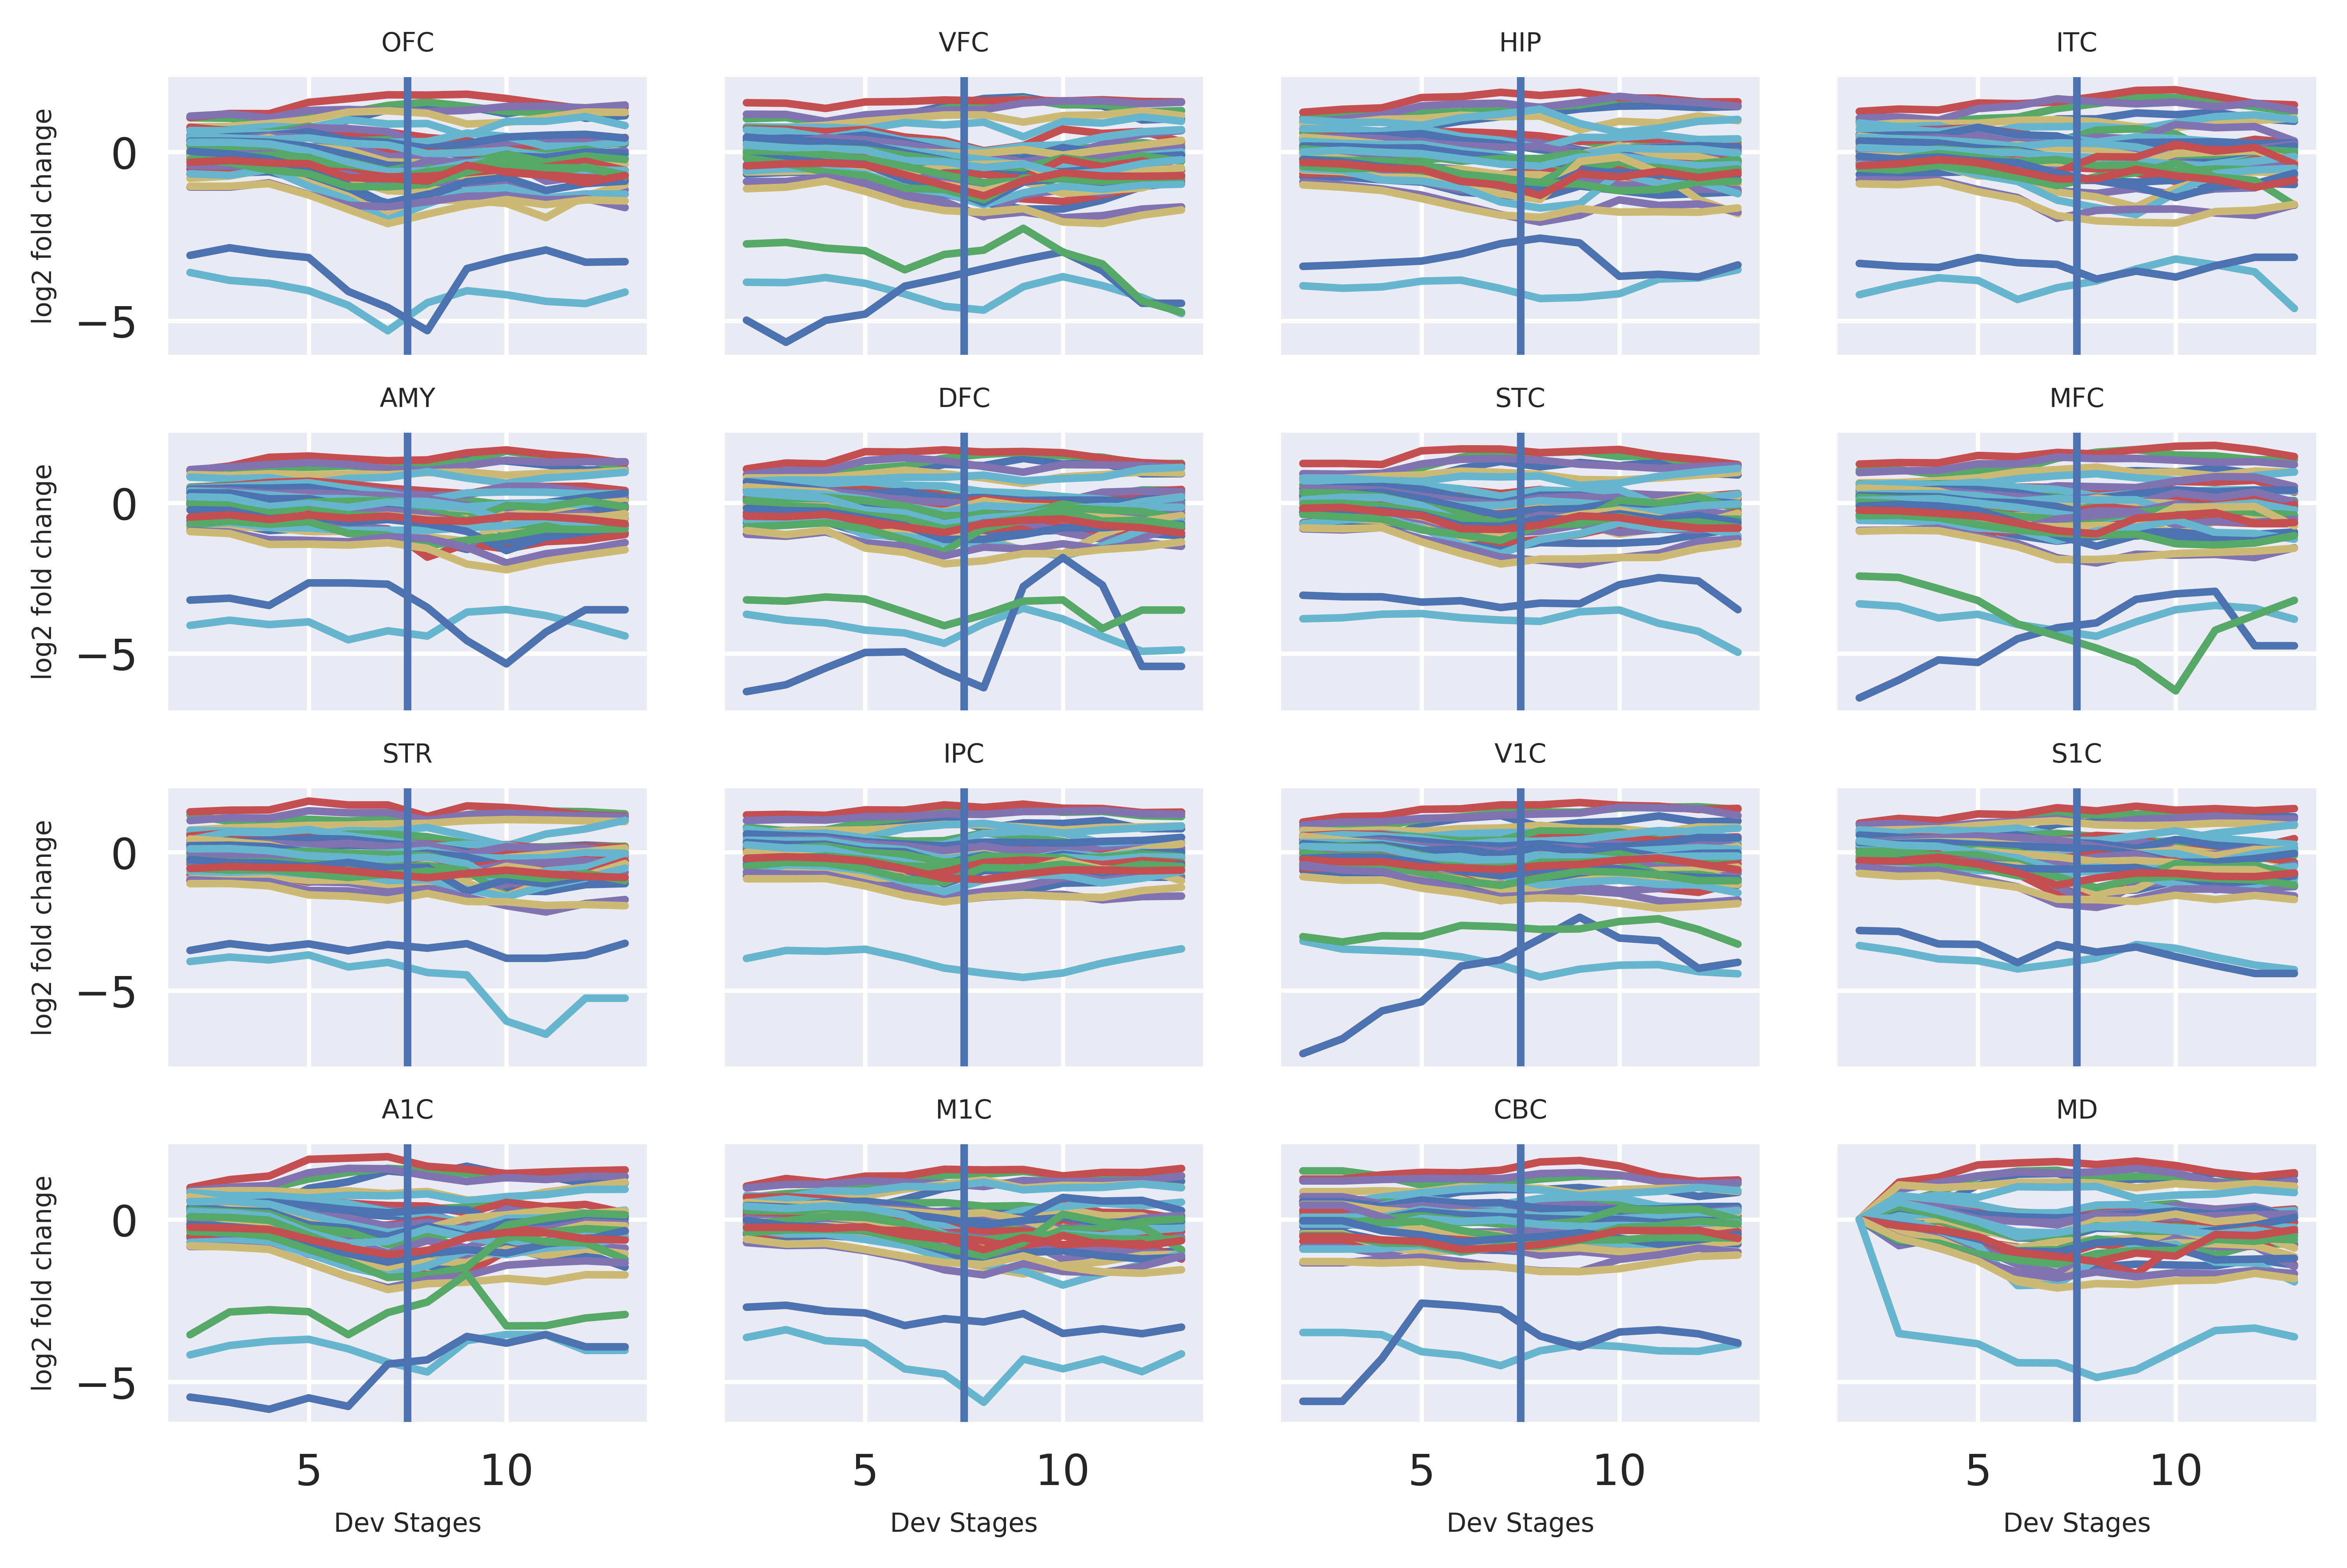

In [136]:
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]
LookGrid("CHD8", Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

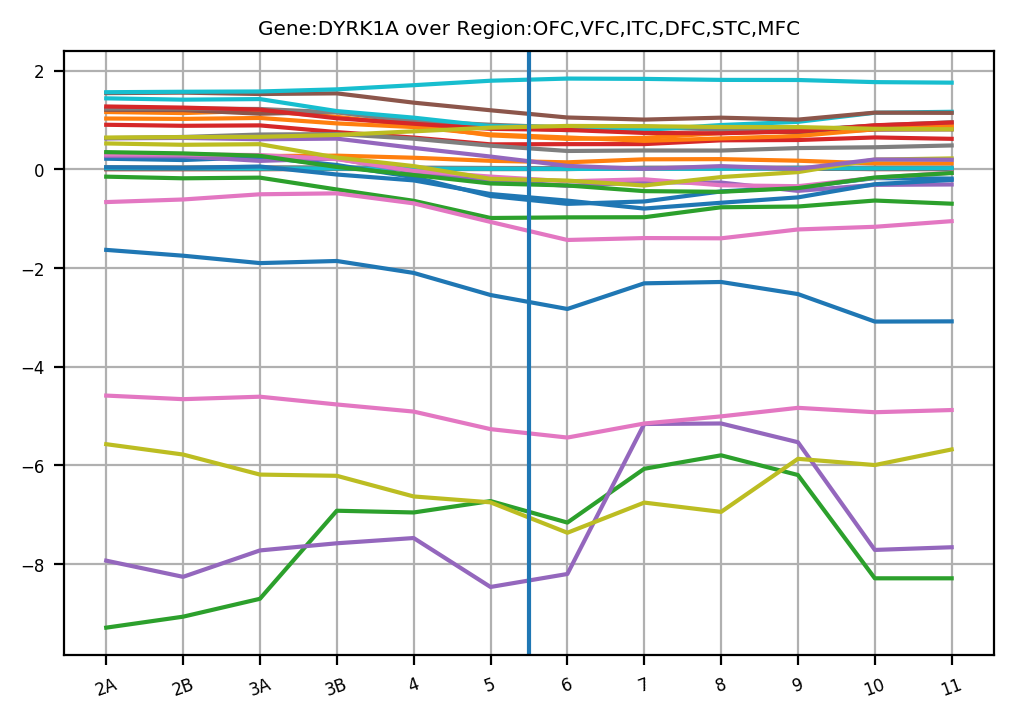

In [33]:
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]
LookGridSumRegion("DYRK1A", Regions, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

In [34]:
VarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/Autism_LGD.csv"
AssignVar2Exon(bp_exon_row_meta, VarFile)
bp_exon_row_meta.head()

309222

row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id     start  \
0        1  1086864  ENSG00000000003      TSPAN6     7105.0  99883666   
1        2  1086864  ENSG00000000003      TSPAN6     7105.0  99885755   
2        3  1086864  ENSG00000000003      TSPAN6     7105.0  99887481   
3        4  1086864  ENSG00000000003      TSPAN6     7105.0  99888401   
4        5  1086864  ENSG00000000003      TSPAN6     7105.0  99888927   

        end  exon length Vars  
0  99884983         1317       
1  99885863          108       
2  99887565           84       
3  99888536          135       
4  99889026           99

In [267]:
VarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014LGD.xlsx"
AssignVar2Exon2(bp_exon_row_meta, VarFile)
bp_exon_row_meta.head()

309222

row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id     start  \
0        1  1086864  ENSG00000000003      TSPAN6     7105.0  99883666   
1        2  1086864  ENSG00000000003      TSPAN6     7105.0  99885755   
2        3  1086864  ENSG00000000003      TSPAN6     7105.0  99887481   
3        4  1086864  ENSG00000000003      TSPAN6     7105.0  99888401   
4        5  1086864  ENSG00000000003      TSPAN6     7105.0  99888927   

        end  exon length Vars  
0  99884983         1317       
1  99885863          108       
2  99887565           84       
3  99888536          135       
4  99889026           99

In [269]:
bp_exon_row_meta_with_var = bp_exon_row_meta[bp_exon_row_meta["Vars"]!=""]
bp_exon_row_meta_with_var.shape
bp_exon_row_meta_with_var.head()
bp_exon_row_meta_with_var.to_csv("ExonsTargetedByLGD_wilger2014_predicted.csv",index=False)

[7.4902499615384608, 8.6504290975609752, 9.4688998928571415, 8.3067933823529412, 7.1265310192307689, 4.8443070921052627, 3.8920449696969701, 4.5686204500000001, 3.5984863304347834, 3.3649878499999999, 4.1597972800000003, 4.5505175217391329]
[8.0703395295497184, 8.5365263173188595, 8.8087074575903532, 8.300741431480283, 6.7592104978963237, 5.2876276936776678, 4.4349908372674109, 4.0197172500439171, 3.8440315434782613, 3.7077571534782607, 4.0251008839130442, 4.355157400869567]


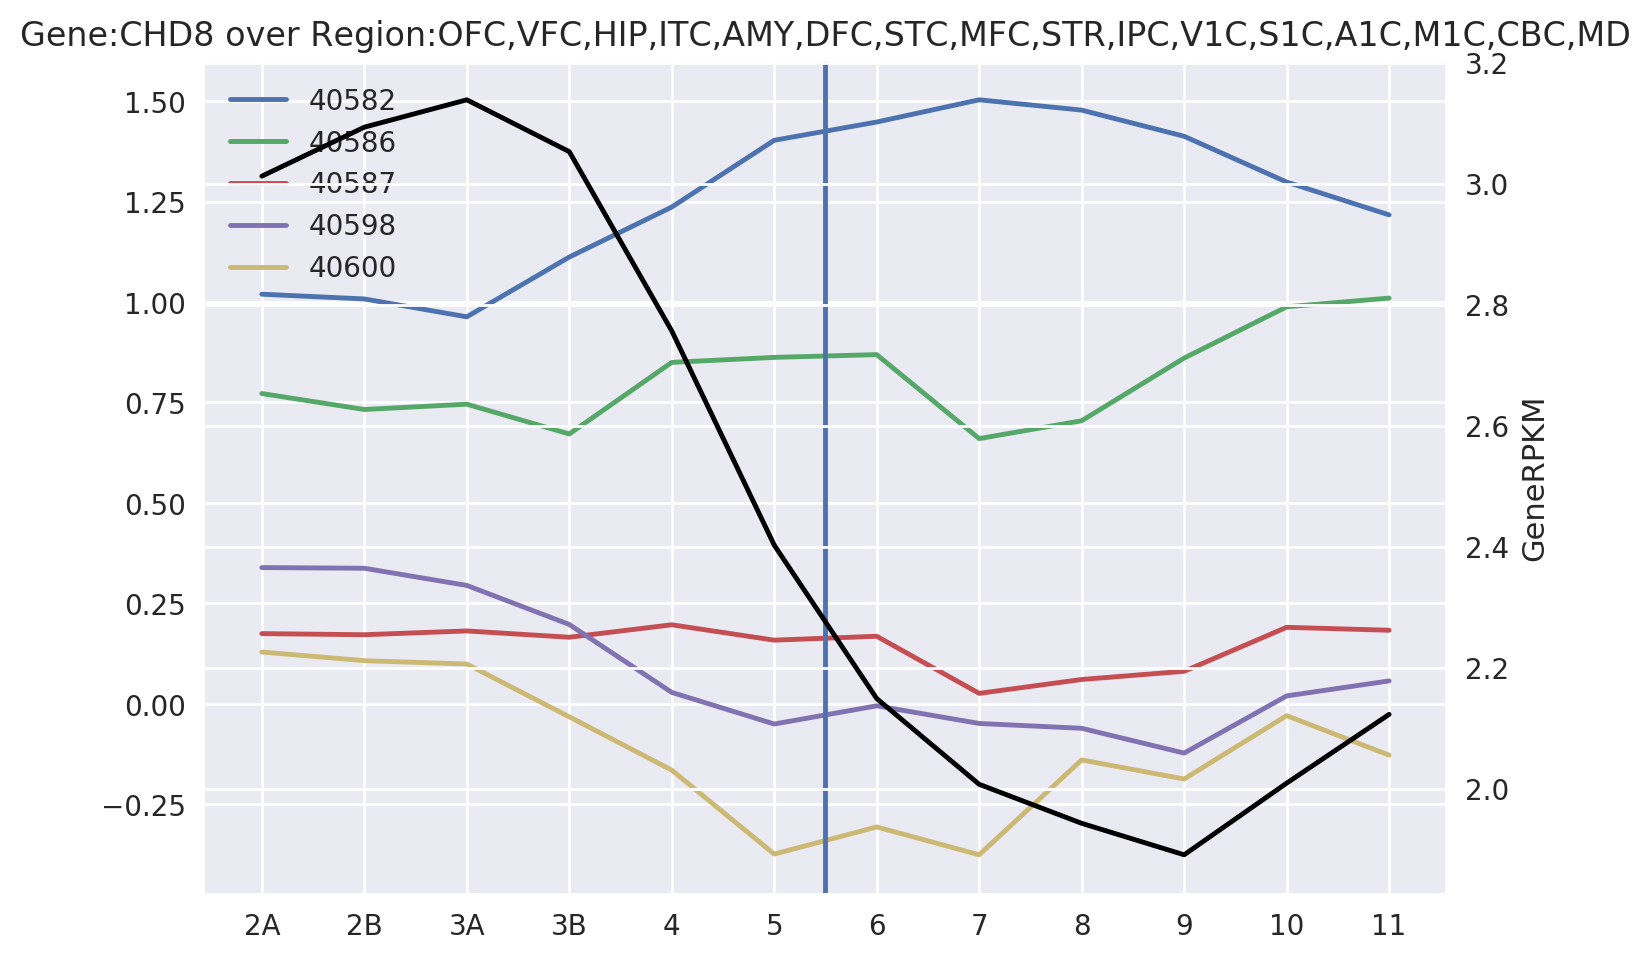

In [276]:
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]
LookMutationTargetedExon("CHD8", Regionsgt20, bp_exon_row_meta_with_var, bp_exon_col_meta, NormExonExp, GeneDat)
#LookMutationTargetedExon("CHD8", Regions, bp_exon_row_meta_with_var, M_bp_exon_col_meta, NormExonExp)
#LookMutationTargetedExon("CHD8", Regions, bp_exon_row_meta_with_var, F_bp_exon_col_meta, NormExonExp)

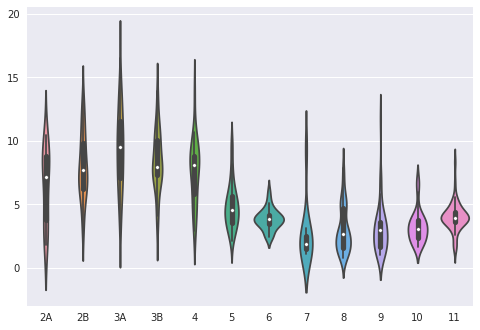

In [154]:
DisplayGeneExpViolin("ARID1B", GeneDat, Regionsgt20)

In [230]:
VarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/Autism_LGD.csv"
AssignVar2Gene(GeneRow, VarFile)
print GeneRow.head(2)
GeneRow_withVar = GeneRow[GeneRow["Vars"]!=""]
print GeneRow_withVar.head(2)
GeneRow_withVar.shape

52375   row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id Vars
0        1   7062.0  ENSG00000000003      TSPAN6     7105.0     
1        2  40735.0  ENSG00000000005        TNMD    64102.0     
     row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id  \
175      176   9559.0  ENSG00000007202    KIAA0100     9703.0   
203      204   3695.0  ENSG00000008083      JARID2     3720.0   

                 Vars  
175        ;c.3130C>T  
203  ;c.3540_3547del8  


(195, 6)

Loading Genes 194

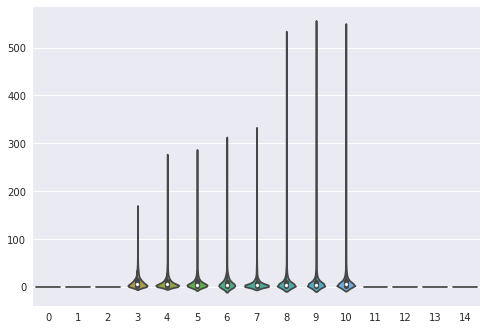

In [231]:
Genes = list(GeneRow_withVar["gene_symbol"])
DisplayGeneSumExpViolin(Genes, GeneDat, Regionsgt20)

Loading Genes 194

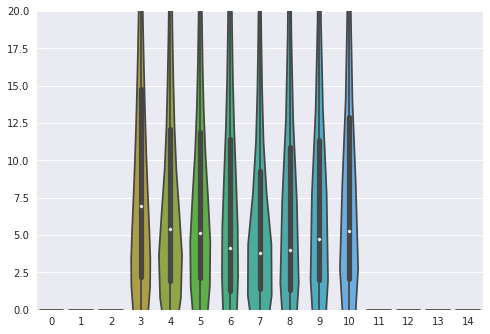

In [232]:
Genes = list(GeneRow_withVar["gene_symbol"])
DisplayGeneSumExpViolin(Genes, GeneDat, Regionsgt20, ylim=(0,20))

Loading Genes 194

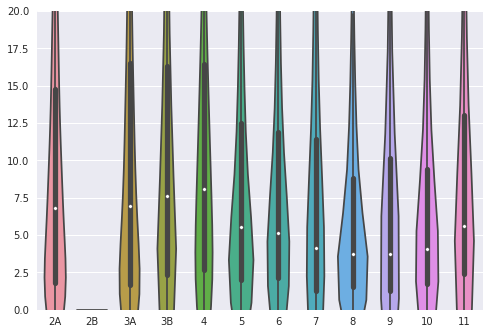

Loading Genes 194

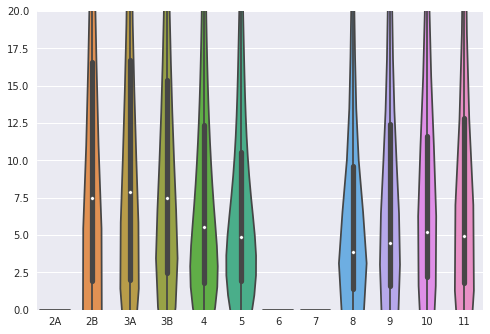

In [185]:
M_bp_gene_col_meta = GeneCol[GeneCol["gender"]=="M"]
F_bp_gene_col_meta = GeneCol[GeneCol["gender"]=="F"]
M_GeneDat, F_GeneDat = (GeneExp, GeneRow, M_bp_gene_col_meta), (GeneExp, GeneRow, F_bp_gene_col_meta)
DisplayGeneSumExpViolin(Genes, M_GeneDat, Regionsgt20, ylim=(0,20))
DisplayGeneSumExpViolin(Genes, F_GeneDat, Regionsgt20, ylim=(0,20))

1
14
15


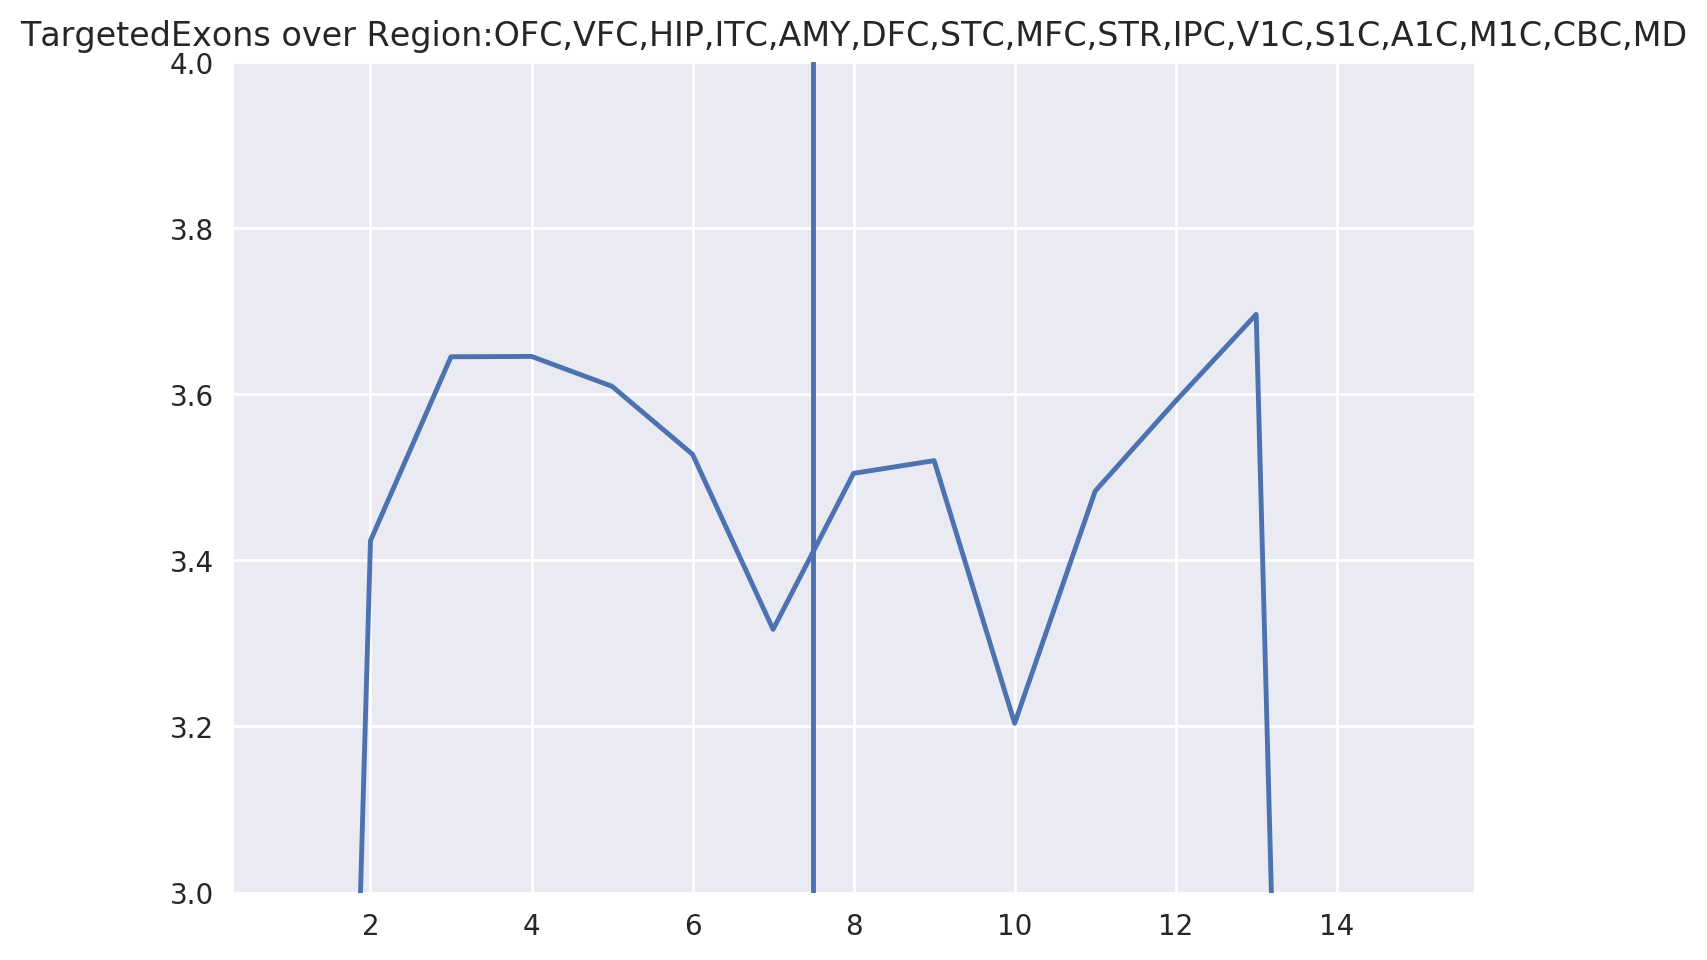

In [244]:
#LookALLMutationTargetedGenes(Genes, Regionsgt20, GeneDat, ylim=(8,13))
LookALLMutationTargetedGenes(Genes, Regionsgt20, GeneDat, ylim=(3,4), smooth=False)

In [245]:
rec_lgd_entrez_id = [x.strip() for x in file("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler-rec-lgd.txt")]
print rec_lgd_entrez_id 
bs_GeneRow = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/genes_microarray/rows_metadata.csv")
rec_lgd_gene_symbols = list(bs_GeneRow[bs_GeneRow["entrez_id"].isin(rec_lgd_entrez_id)]["gene_symbol"])
print len(rec_lgd_gene_symbols), rec_lgd_gene_symbols

['23126', '10765', '10716', '6326', '10787', '27086', '23001', '287', '22999', '57492', '64599', '55904', '5253', '51322', '6934', '2904', '23389', '57680', '1106', '29123', '23135', '83473', '23394', '1859', '1826', '23181', '23112']
26 ['SCN2A', 'NCKAP1', 'GRIN2B', 'DYRK1A', 'TNRC6B', 'ARID1B', 'MED13L', 'ANK2', 'POGZ', 'ANKRD11', 'DIP2A', 'FOXP1', 'RIMS1', 'GIGYF1', 'KDM6B', 'MLL5', 'DSCAM', 'KATNAL2', 'TCF7L2', 'WAC', 'ADNP', 'PHF2', 'WDFY3', 'CHD2', 'KDM5B', 'TBR1']


1
14
15


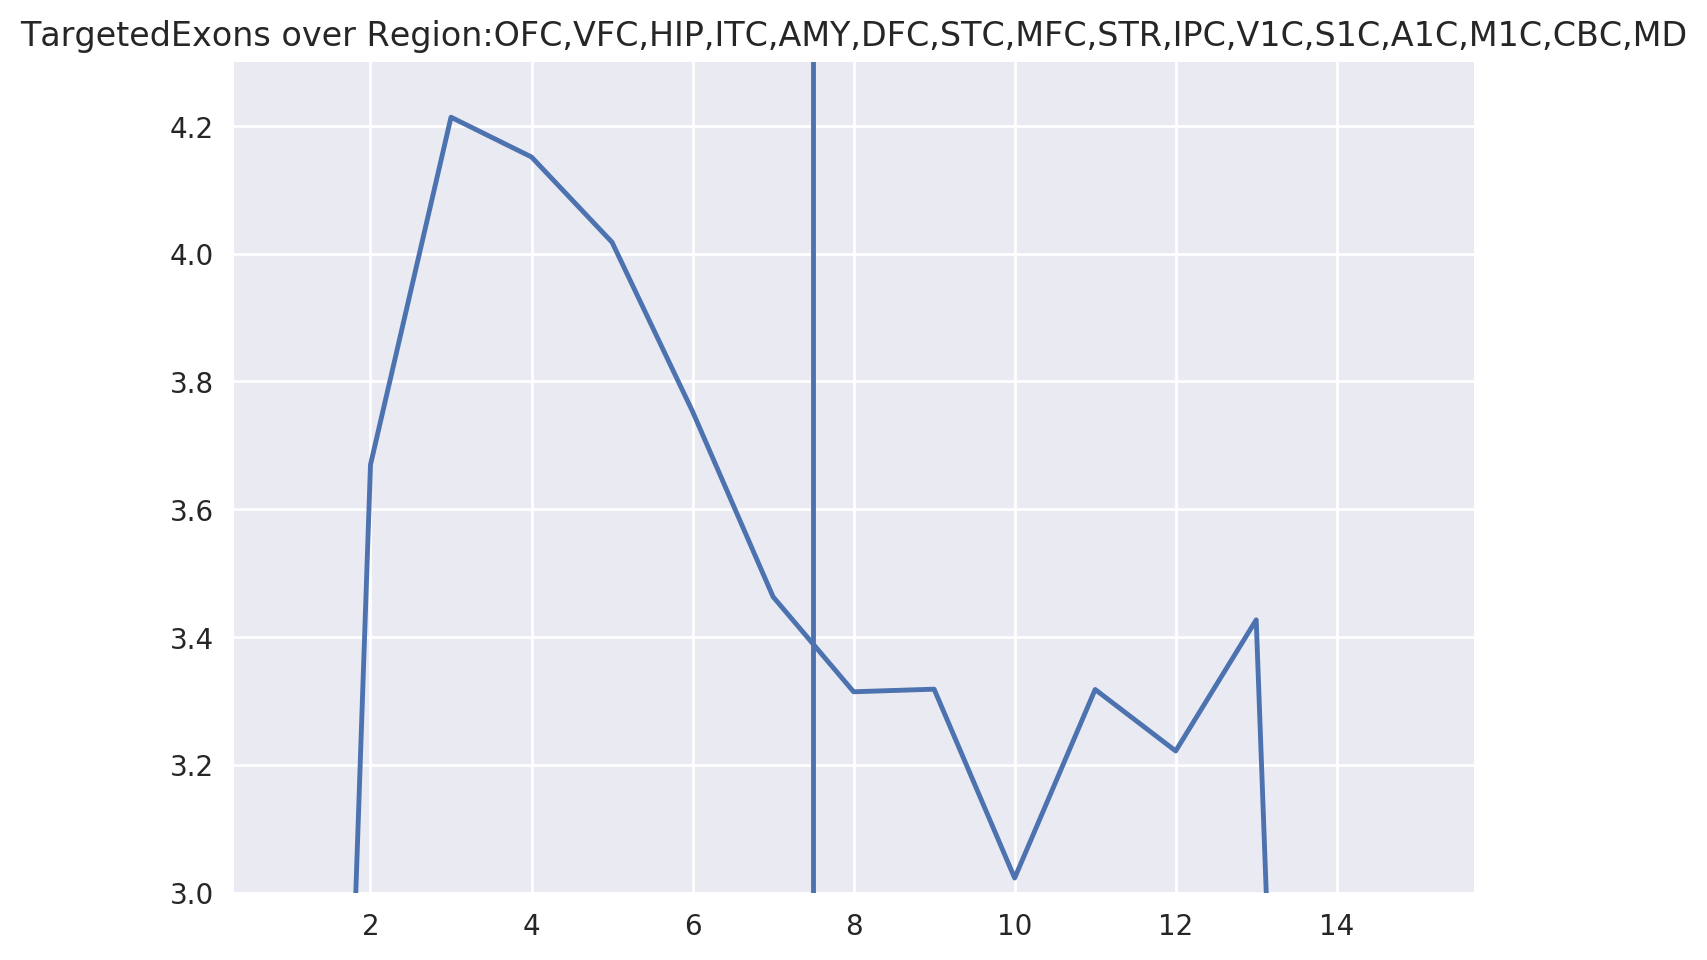

In [248]:
LookALLMutationTargetedGenes(rec_lgd_gene_symbols, Regionsgt20, GeneDat, ylim=(3,4.3), smooth=False)

Loading Genes 1003

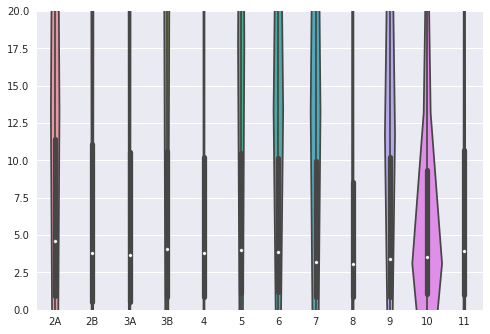

In [137]:
test_genes = GeneRow.head(1000)["gene_symbol"]
DisplayGeneSumExpViolin(test_genes, GeneDat, Regionsgt20)

In [37]:
M_bp_exon_col_meta = bp_exon_col_meta[bp_exon_col_meta["gender"]=="M"]
F_bp_exon_col_meta = bp_exon_col_meta[bp_exon_col_meta["gender"]=="F"]

[1265, 1280, 1975, 2903, 3547, 3911, 4318, 5171, 5494, 5921, 6700, 7204, 8204, 8760, 9374, 10869, 10989, 11546, 11552, 11694, 13108, 14590, 14616, 16220, 17619, 19207, 20024, 20634, 21173, 22272, 23792, 24158, 25883, 26001, 26077, 26255, 26287, 26679, 26742, 27395, 28184, 28311, 28446, 28748, 28770, 31164, 33621, 34566, 35370, 35764, 35877, 35982, 35985, 36976, 37087, 39026, 39616, 40535, 40582, 40586, 40587, 40598, 40600, 40934, 41150, 44414, 44764, 46960, 47315, 47536, 48345, 49423, 49446, 50596, 51908, 52864, 53213, 53918, 54477, 54568, 55652, 55719, 55786, 57929, 58138, 61163, 61780, 62713, 62739, 64668, 65213, 65963, 66473, 66477, 67436, 68188, 69390, 69556, 70038, 70541, 71276, 71282, 71506, 72399, 73055, 73192, 73373, 74592, 74984, 75103, 75619, 77754, 78000, 79519, 79524, 80364, 80543, 80672, 81965, 82596, 83048, 83183, 84122, 85141, 85670, 86648, 87594, 87654, 88201, 88930, 91061, 91451, 91724, 93812, 94075, 94585, 95079, 96420, 96916, 97710, 98138, 98670, 99105, 99401, 100045

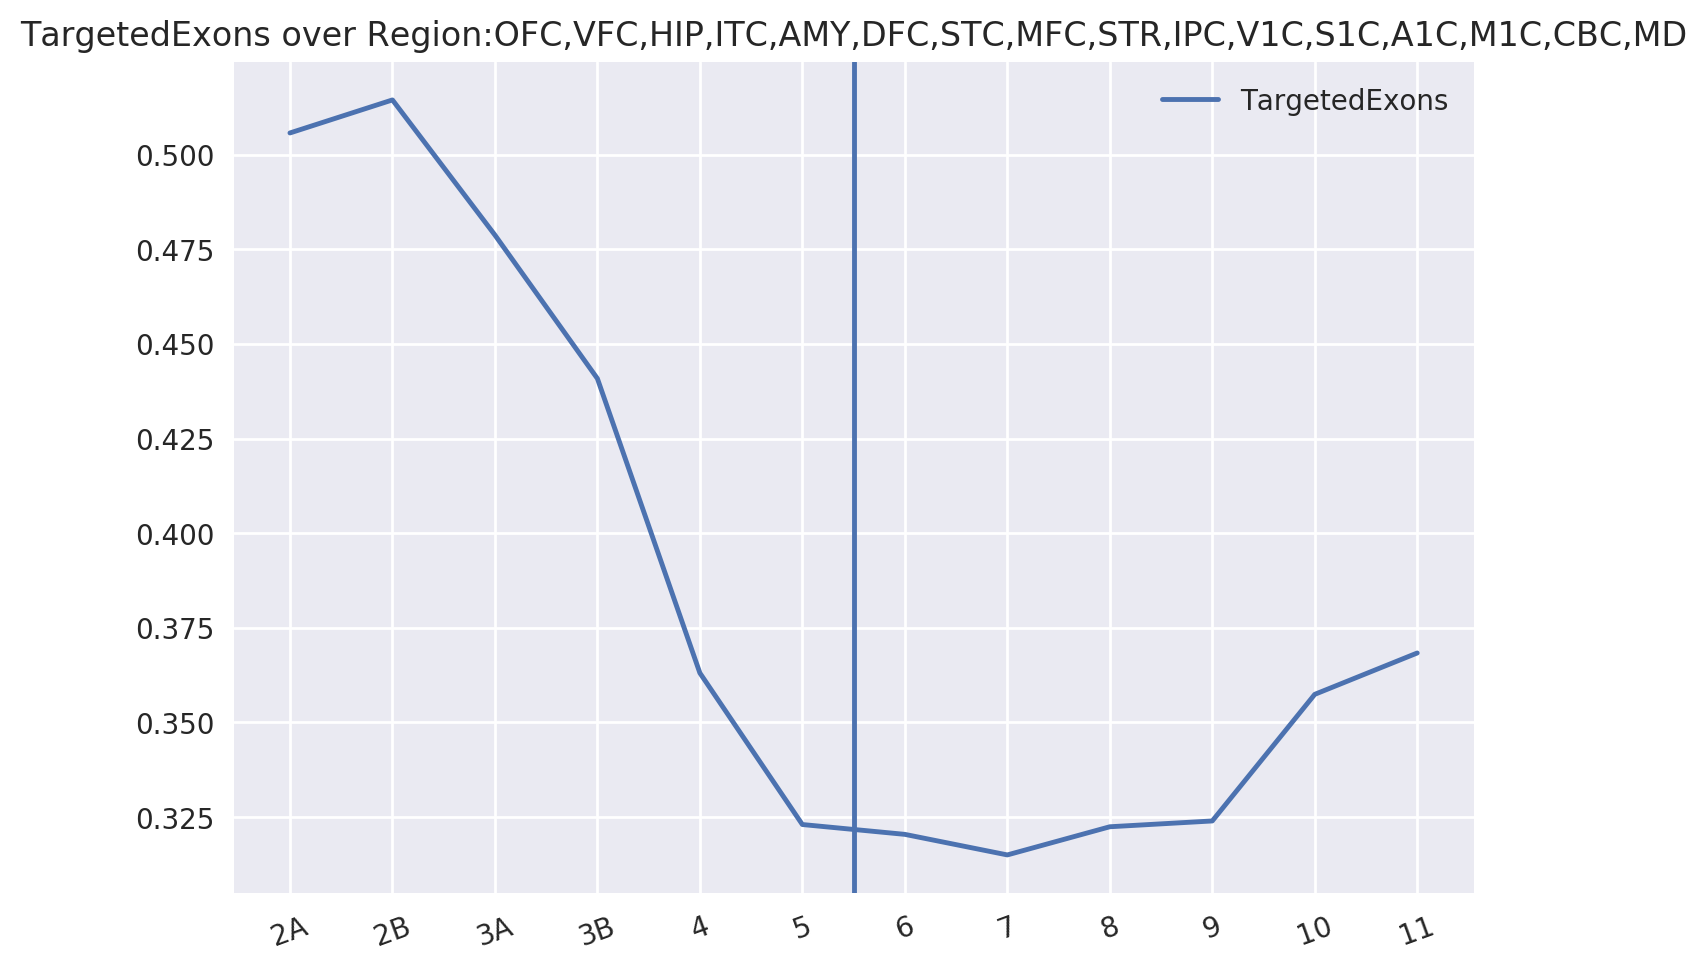

In [299]:
selected_exons = list(bp_exon_row_meta_with_var["row_num"])
lengths = LookALLMutationTargetedExon(selected_exons, Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, NormExonExp)

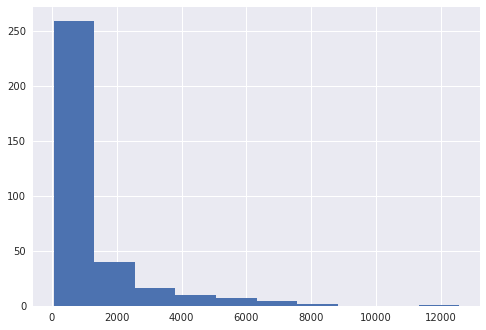

       row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id      start  \
1974      1975  1086984  ENSG00000006062     MAP3K14     9020.0   43340487   
5170      5171  1087175  ENSG00000012048       BRCA1      672.0   41196311   
8203      8204  1087365  ENSG00000032742       IFT88     8100.0   21205154   
11551    11552  1087537  ENSG00000049618      ARID1B    57492.0  157527300   
11693    11694  1087548  ENSG00000050344      NFE2L3     9603.0   26223679   

             end  exon length          Vars  
1974    43342167         1680  ;17:43342073  
5170    41197819         1508  ;17:41197776  
8203    21206278         1124  ;13:21205235  
11551  157530401         3101  ;6:157527665  
11693   26226745         3066   ;7:26224579  
      row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id      start  \
1264     1265  1086943  ENSG00000005108      THSD7A   221981.0   11486856   
1279     1280  1086944  ENSG00000005156        LIG3     3980.0   33313006   
2902     2903  1087037  

In [278]:
plt.hist(lengths)
plt.show()
longexons = bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["exon length"]>=1000]
shortexons = bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["exon length"]<1000]
print longexons.head()
print shortexons.head()

Loading records:92

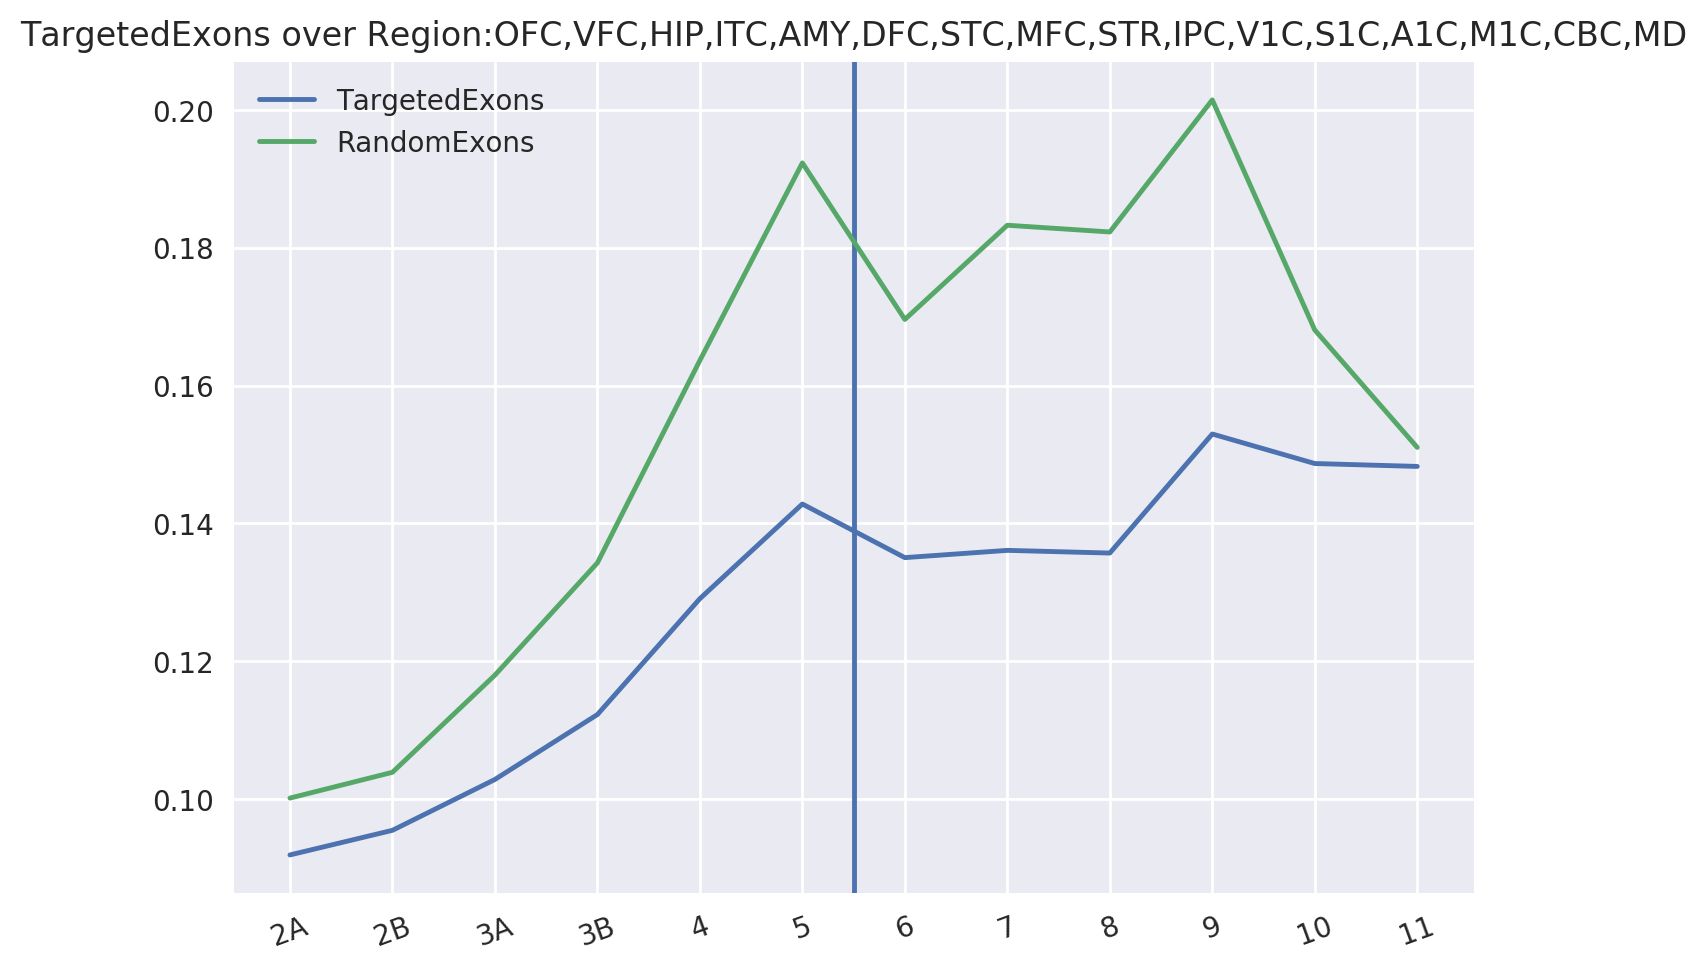

Loading records:245

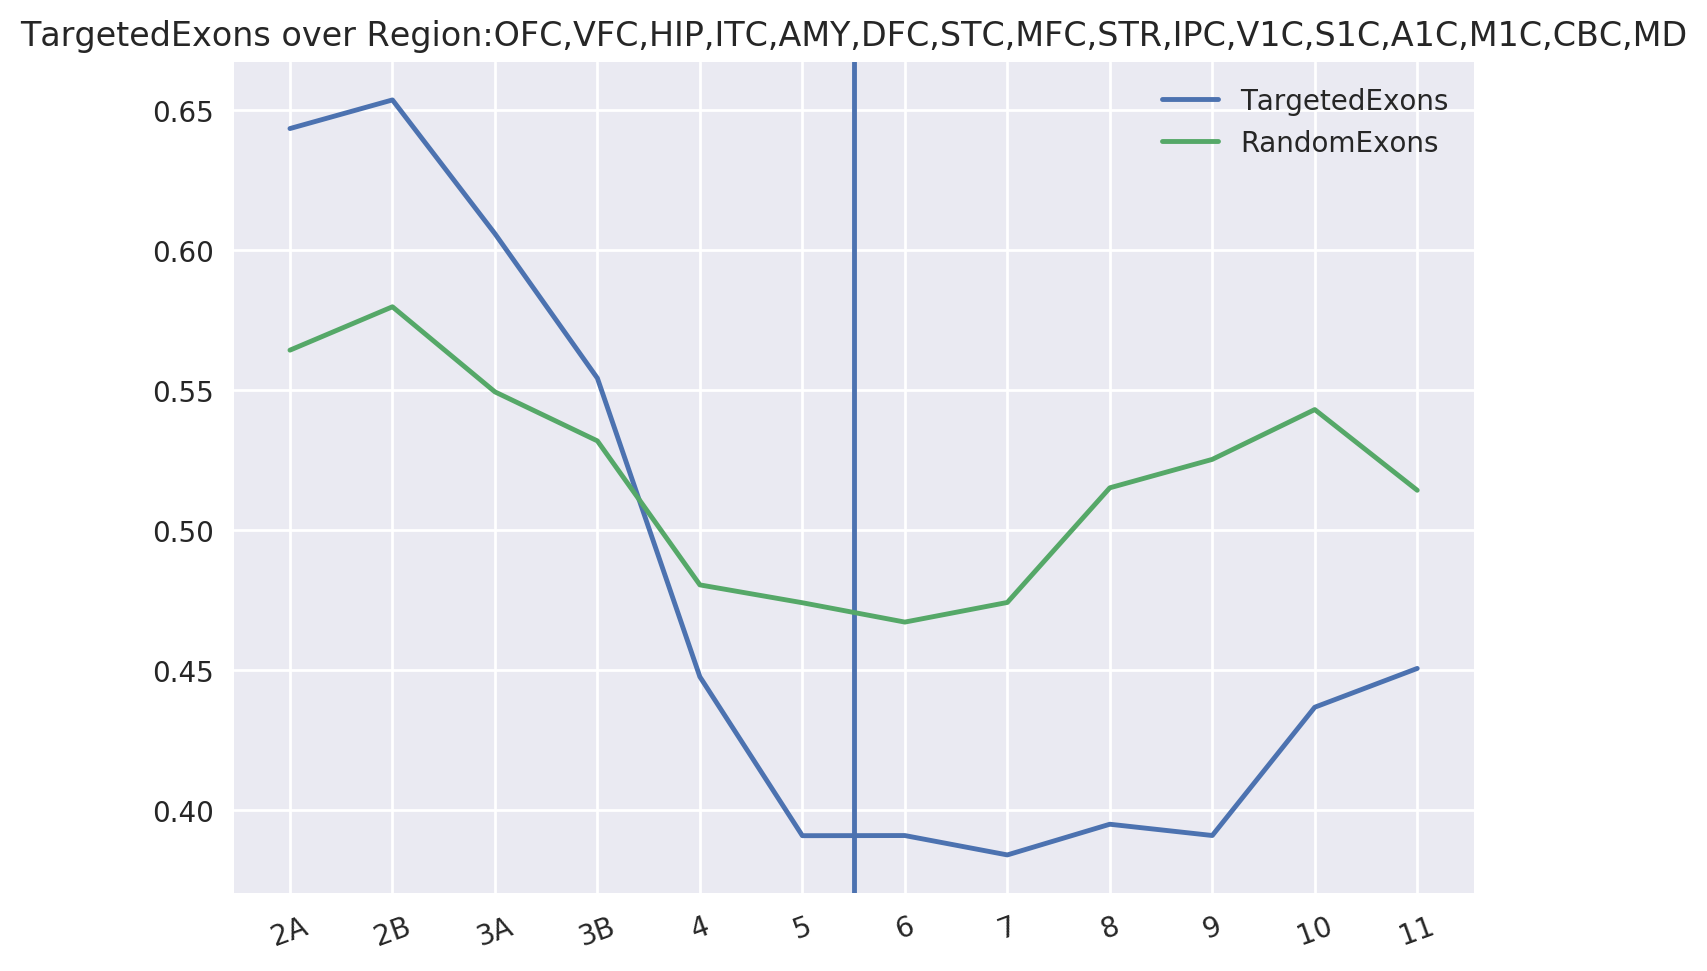

In [300]:
lengths = LookALLMutationTargetedExon(list(longexons["row_num"]), Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, NormExonExp, rd="gt1000")
lengths = LookALLMutationTargetedExon(list(shortexons["row_num"]), Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, NormExonExp, rd="lt1000")

Loading records:92
Loading records:929


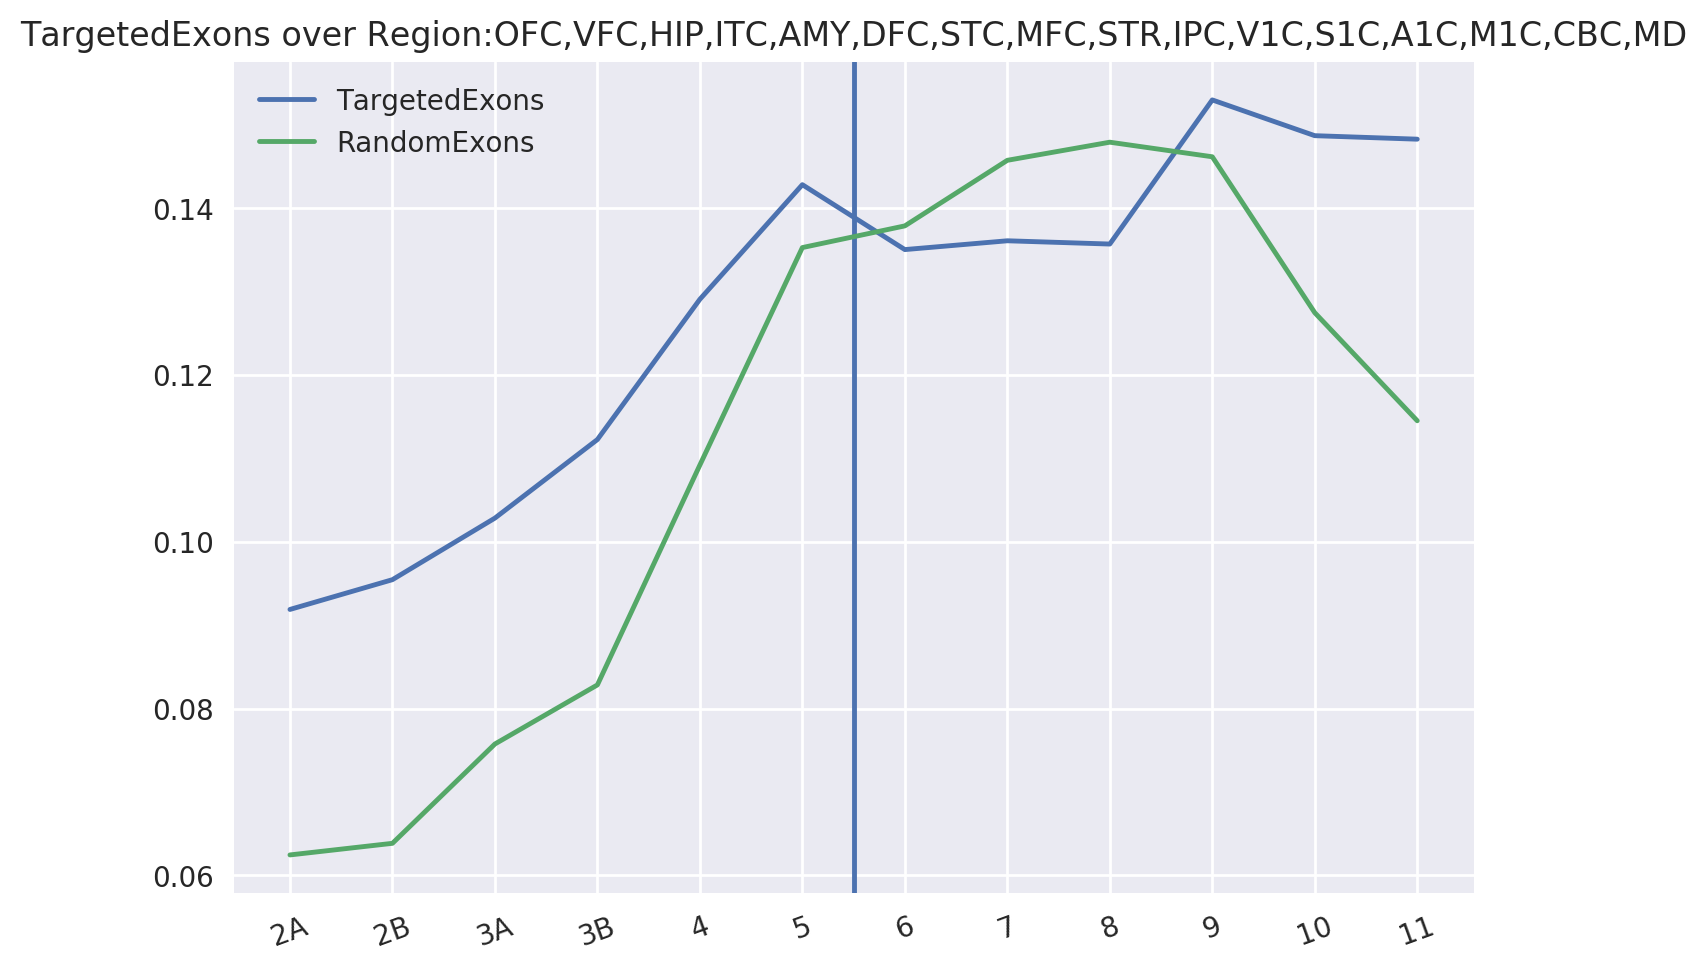

Loading records:245
Loading records:2459


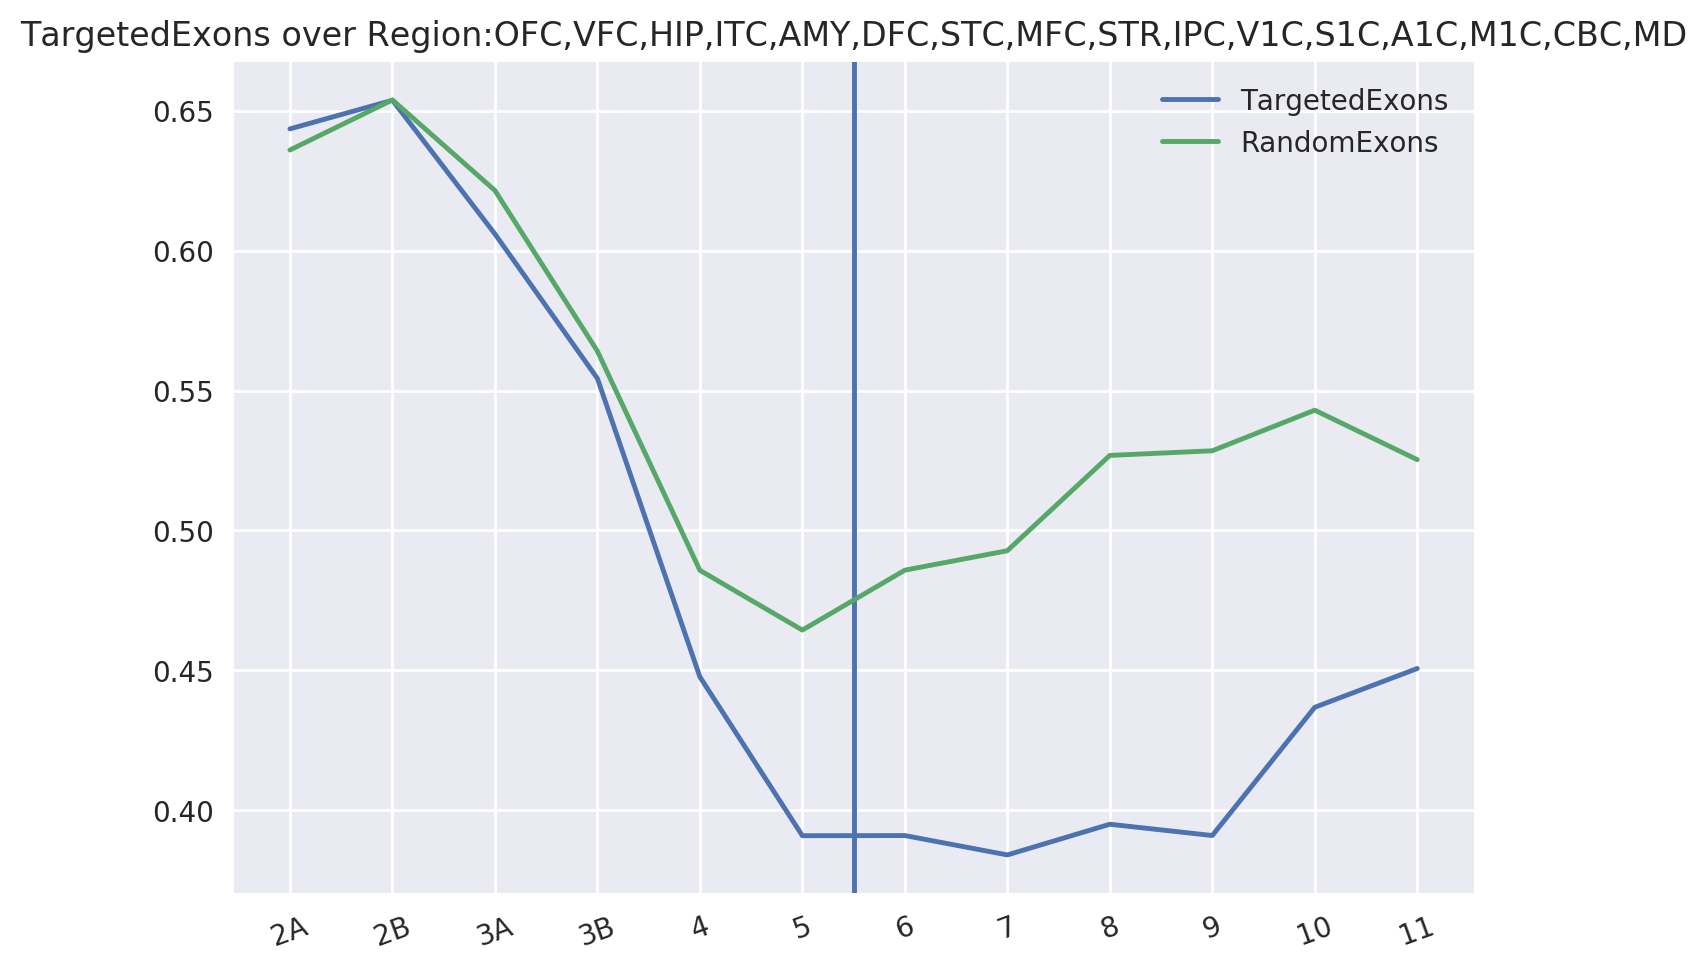

In [301]:
lengths = LookALLMutationTargetedExon(list(longexons["row_num"]), Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, NormExonExp, rd="gt1000")
lengths = LookALLMutationTargetedExon(list(shortexons["row_num"]), Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, NormExonExp, rd="lt1000")

Loading records:92
Loading records:929


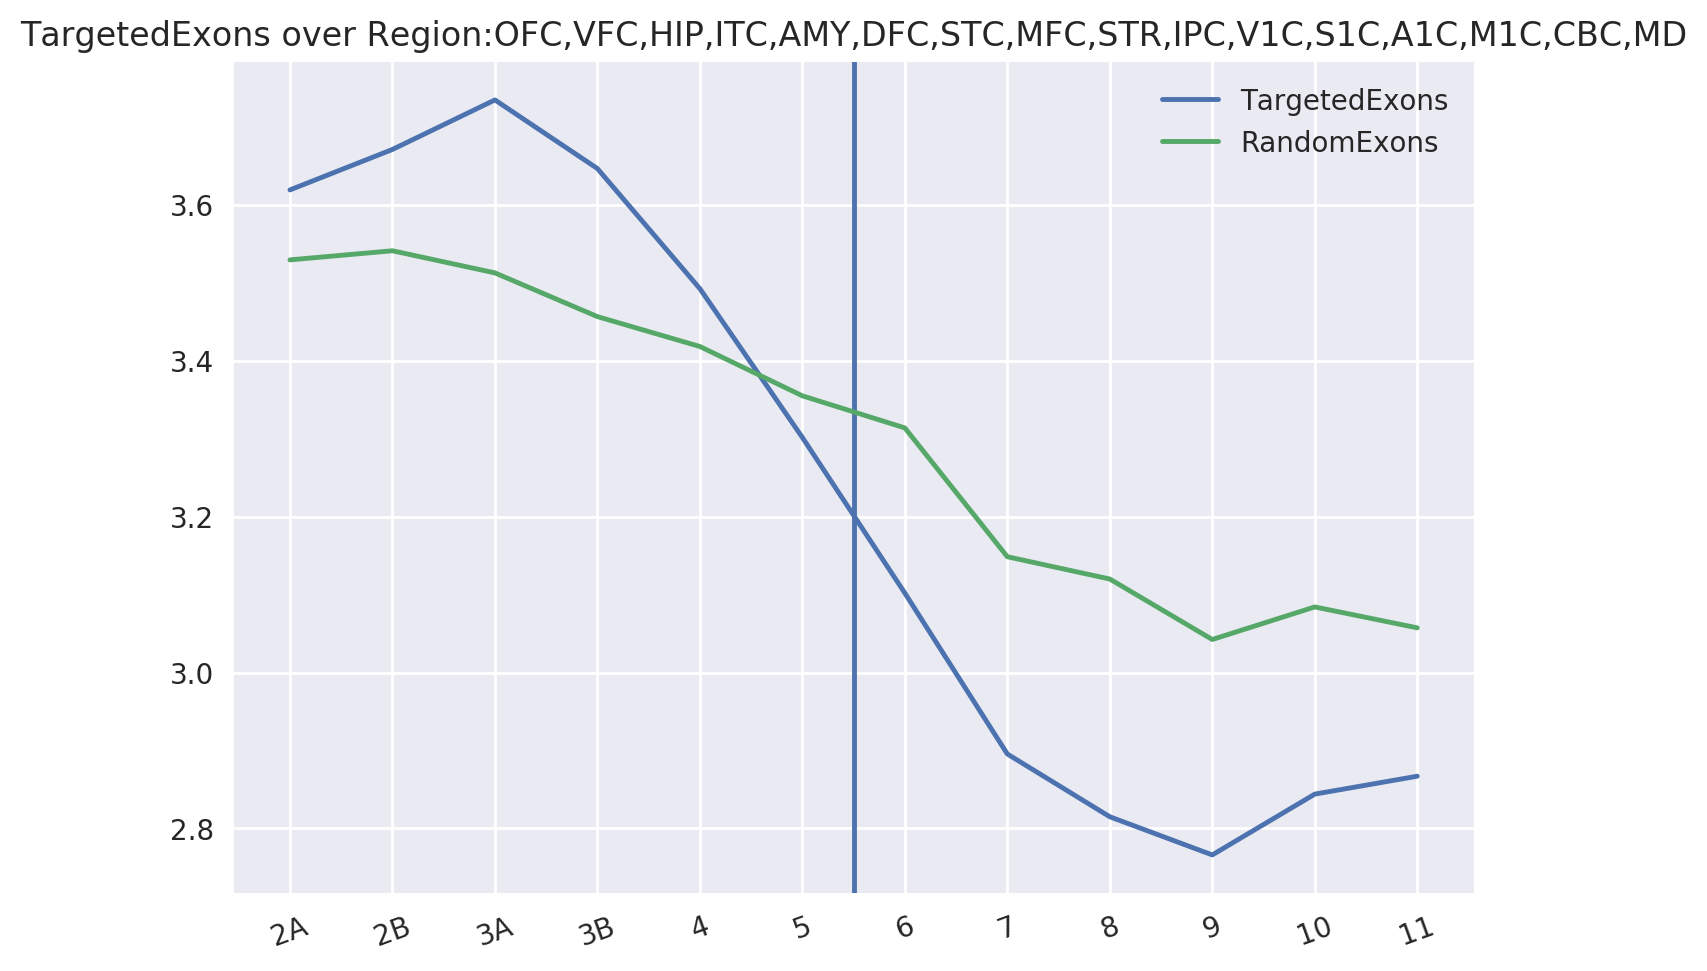

Loading records:245
Loading records:2459


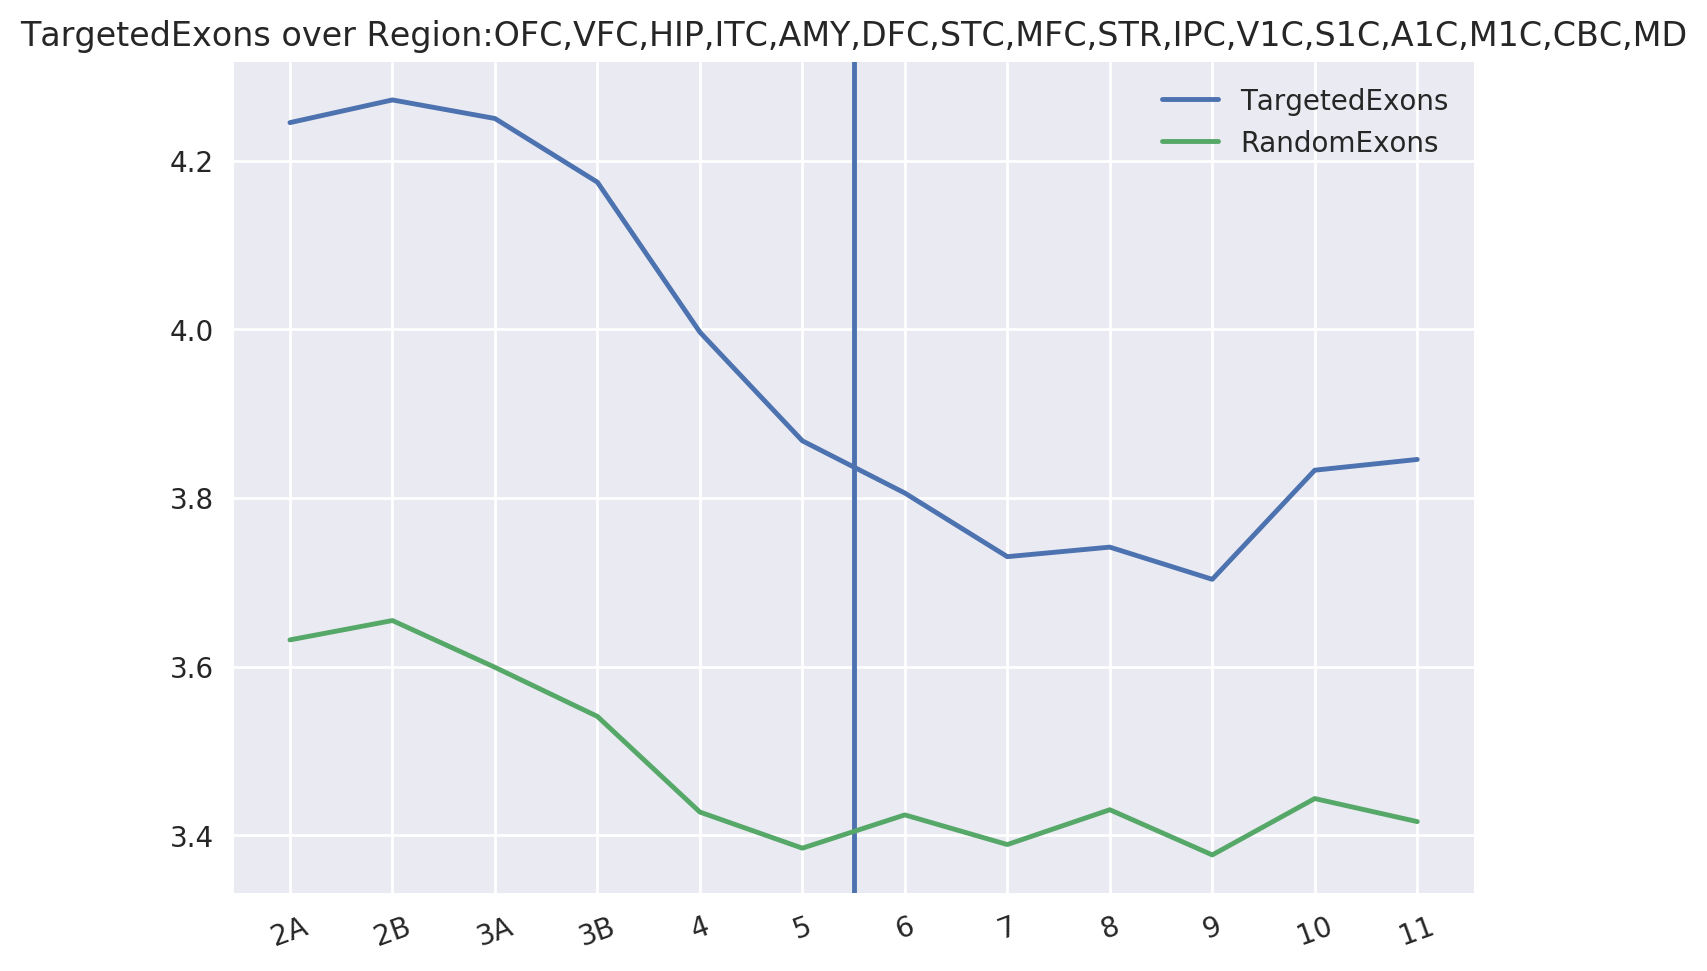

In [302]:
lengths = LookALLMutationTargetedExon(list(longexons["row_num"]), Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, ExonExp, rd="gt1000")
lengths = LookALLMutationTargetedExon(list(shortexons["row_num"]), Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, ExonExp, rd="lt1000")

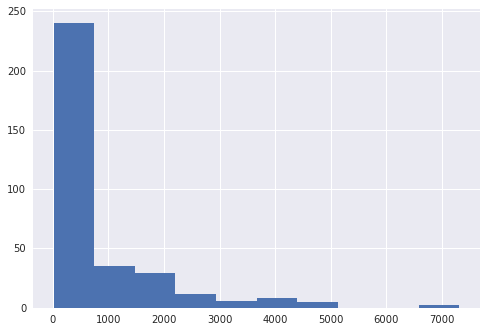

In [283]:
#plt.hist(l1)
#plt.hist(l2)
plt.hist(l1+l2)
plt.show()

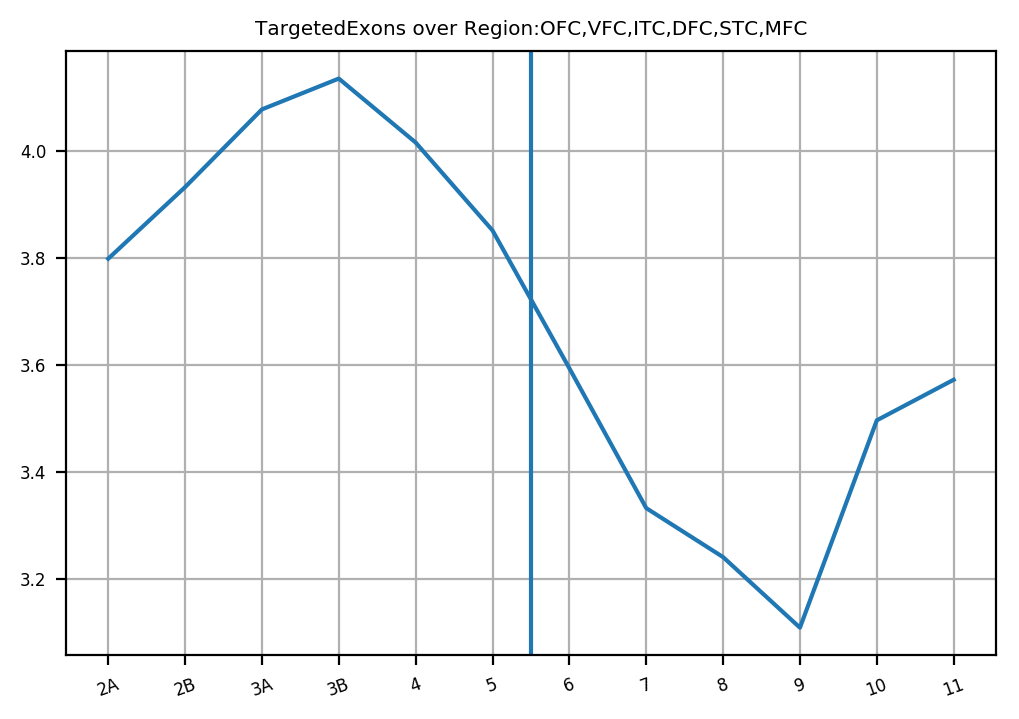

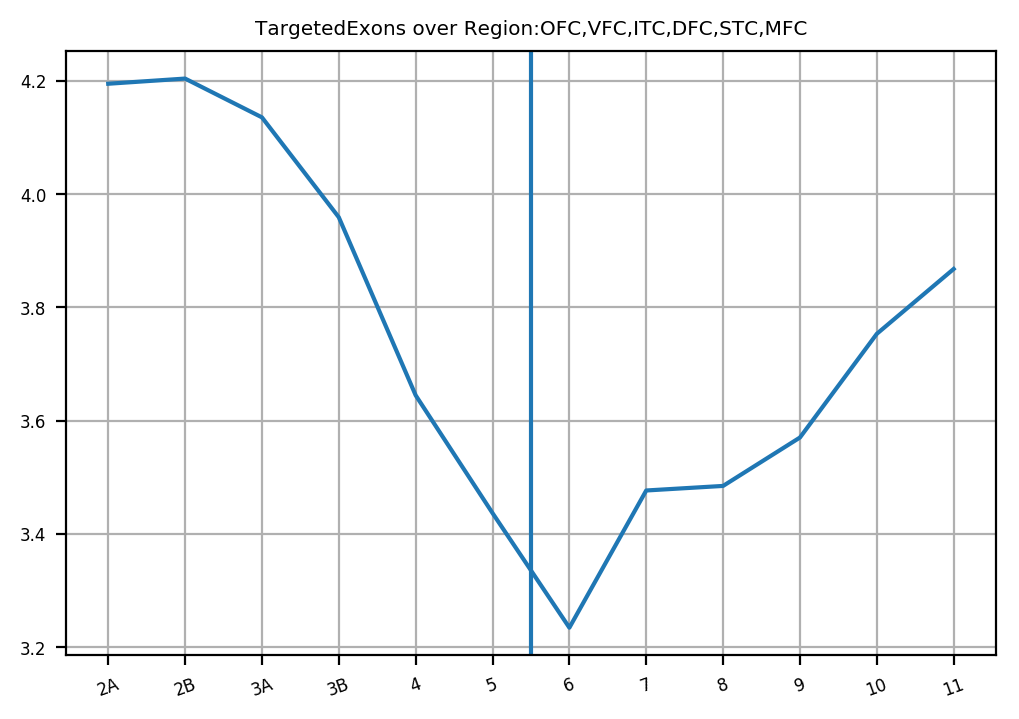

In [39]:
LookALLMutationTargetedExon(Regions, bp_exon_row_meta_with_var, M_bp_exon_col_meta, ExonExp)
LookALLMutationTargetedExon(Regions, bp_exon_row_meta_with_var, F_bp_exon_col_meta, ExonExp)

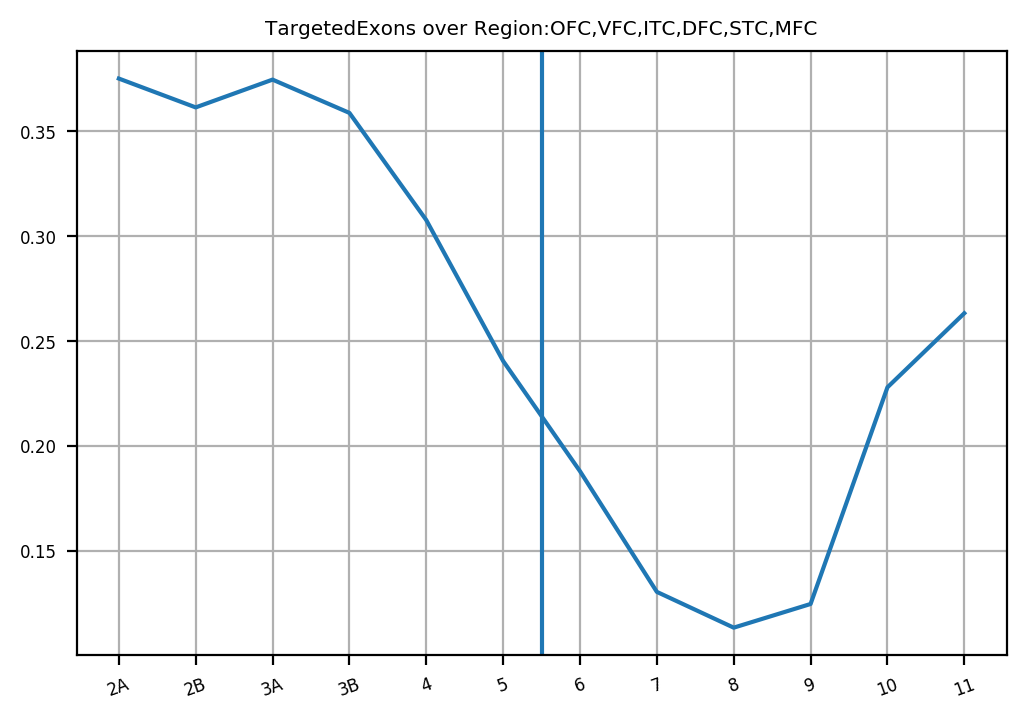

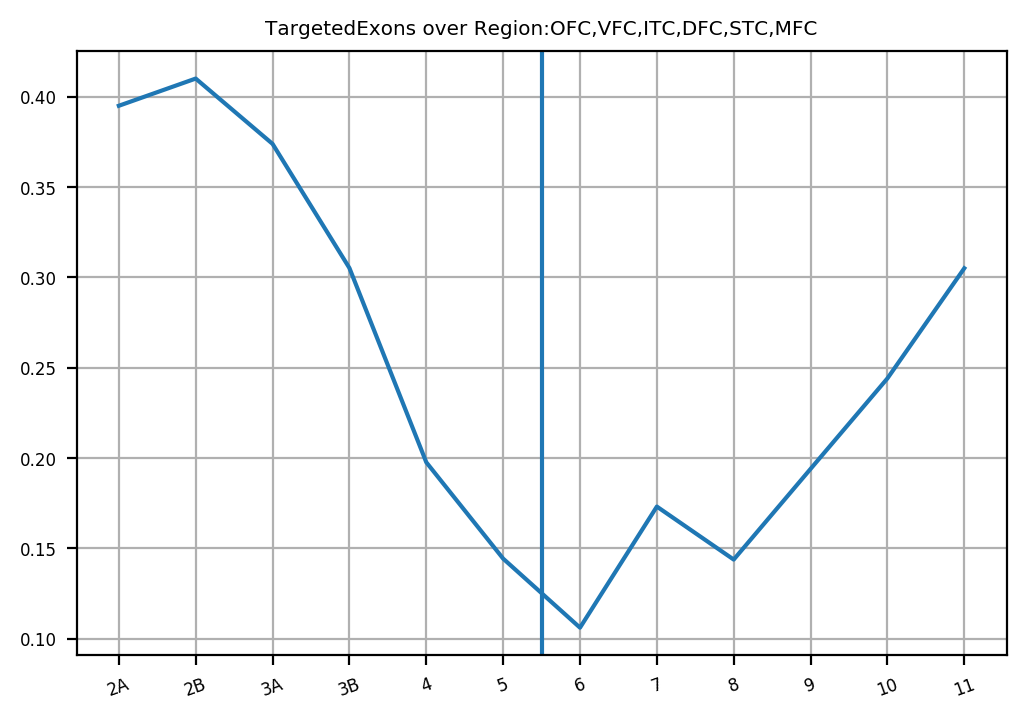

In [40]:
LookALLMutationTargetedExon(Regions, bp_exon_row_meta_with_var, M_bp_exon_col_meta, NormExonExp)
LookALLMutationTargetedExon(Regions, bp_exon_row_meta_with_var, F_bp_exon_col_meta, NormExonExp)

In [41]:
F_bp_exon_col_meta.drop_duplicates("donor_id")

column_num  donor_id    donor_name     age gender  structure_id  \
30           31     12835   H376.IIB.50  12 pcw      F         10333   
45           46     12960   H376.IIB.51  12 pcw      F         10391   
60           61     13060   H376.IIB.52  12 pcw      F         10225   
89           90     12834  H376.IIIA.51  13 pcw      F         10243   
158         159     12880  H376.IIIB.53  17 pcw      F         10278   
172         173     12885    H376.IV.53  19 pcw      F         10185   
183         184     12365    H376.IV.51  21 pcw      F         10657   
215         216     12948     H376.V.51  25 pcw      F         10236   
216         217     12949     H376.V.52  26 pcw      F         10173   
219         220     12295     H376.V.50  35 pcw      F         10185   
280         281     12830  H376.VIII.51   1 yrs      F         10657   
296         297     12979  H376.VIII.53   2 yrs      F         10657   
308         309     12836  H376.VIII.52   3 yrs      F         10252   
367         368     12289    H376.IX.50  11 yrs      F         10252   
381         382     12831     H376.X.51  13 yrs      F         10163   
415         416     12832     H376.X.52  19 yrs      F         10278   
431         432     13057    H376.XI.60  21 yrs      F         10163   
461         462     12290    H376.XI.52  30 yrs      F         10278   
509         510     12304    H376.XI.56  40 yrs      F         10361   

    structure_acronym                                     structure_name  \
30                STR                                           striatum   
45                DTH                                    dorsal thalamus   
60                IPC          posteroventral (inferior) parietal cortex   
89                STC  posterior (caudal) superior temporal cortex (a...   
158               MFC  anterior (rostral) cingulate (medial prefronta...   
172               VFC                    ventrolateral prefrontal cortex   
183               CBC                                  cerebellar cortex   
215               A1C                     primary auditory cortex (core)   
216               DFC                     dorsolateral prefrontal cortex   
219               VFC                    ventrolateral prefrontal cortex   
280               CBC                                  cerebellar cortex   
296               CBC                                  cerebellar cortex   
308               ITC  inferolateral temporal cortex (area TEv, area 20)   
367               ITC  inferolateral temporal cortex (area TEv, area 20)   
381               M1C             primary motor cortex (area M1, area 4)   
415               MFC  anterior (rostral) cingulate (medial prefronta...   
431               M1C             primary motor cortex (area M1, area 4)   
461               MFC  anterior (rostral) cingulate (medial prefronta...   
509               AMY                                 amygdaloid complex   

    Period         Description  
30      2B      Early prenatal  
45      2B      Early prenatal  
60      2B      Early prenatal  
89      3A  Early mid-prenatal  
158     3B  Early mid-prenatal  
172      4   Late mid-prenatal  
183      4   Late mid-prenatal  
215      5       Late prenatal  
216      5       Late prenatal  
219      5       Late prenatal  
280      8     Early childhood  
296      8     Early childhood  
308      8     Early childhood  
367      9      Late childhood  
381     10         Adolescence  
415     11           Adulthood  
431     11           Adulthood  
461     11           Adulthood  
509     11           Adulthood

In [42]:
M_bp_exon_col_meta.drop_duplicates("donor_id")

column_num   donor_id    donor_name     age gender  structure_id  \
0             1      13058   H376.IIA.51   8 pcw      M         10665   
16           17      12833   H376.IIA.50   9 pcw      M         10291   
75           76      12820  H376.IIIA.50  13 pcw      M         10194   
105         106      12888  H376.IIIA.52  13 pcw      M         10185   
119         120      12287  H376.IIIB.50  16 pcw      M         10185   
129         130      12837  H376.IIIB.51  16 pcw      M         10657   
145         146      12879  H376.IIIB.52  16 pcw      M         10269   
185         186      12886    H376.IV.54  21 pcw      M         10333   
199         200      12288    H376.IV.50  24 pcw      M         10185   
221         222  263195015     H376.V.53  37 pcw      M         10173   
237         238      12296    H376.VI.50   4 mos      M         10269   
246         247      12889    H376.VI.51   4 mos      M         10194   
254         255      12890    H376.VI.52   4 mos      M         10294   
270         271      12977   H376.VII.51  10 mos      M         10278   
319         320      12980  H376.VIII.54   3 yrs      M         10294   
333         334      12298  H376.VIII.50   4 yrs      M         10173   
340         341      12841    H376.IX.51   8 yrs      M         10209   
356         357      12981    H376.IX.52   8 yrs      M         10294   
397         398      12299     H376.X.50  15 yrs      M         10243   
402         403      12984     H376.X.53  18 yrs      M         10278   
447         448      12300    H376.XI.50  23 yrs      M         10398   
477         478      12302    H376.XI.53  36 yrs      M         10173   
493         494      12303    H376.XI.54  37 yrs      M         10173   

    structure_acronym                                     structure_name  \
0                 URL                        upper (rostral) rhombic lip   
16            M1C-S1C             primary motor-sensory cortex (samples)   
75                OFC                             orbital frontal cortex   
105               VFC                    ventrolateral prefrontal cortex   
119               VFC                    ventrolateral prefrontal cortex   
129               CBC                                  cerebellar cortex   
145               V1C  primary visual cortex (striate cortex, area V1...   
185               STR                                           striatum   
199               VFC                    ventrolateral prefrontal cortex   
221               DFC                     dorsolateral prefrontal cortex   
237               V1C  primary visual cortex (striate cortex, area V1...   
246               OFC                             orbital frontal cortex   
254               HIP                hippocampus (hippocampal formation)   
270               MFC  anterior (rostral) cingulate (medial prefronta...   
319               HIP                hippocampus (hippocampal formation)   
333               DFC                     dorsolateral prefrontal cortex   
340               S1C  primary somatosensory cortex (area S1, areas 3...   
356               HIP                hippocampus (hippocampal formation)   
397               STC  posterior (caudal) superior temporal cortex (a...   
402               MFC  anterior (rostral) cingulate (medial prefronta...   
447                MD                    mediodorsal nucleus of thalamus   
477               DFC                     dorsolateral prefrontal cortex   
493               DFC                     dorsolateral prefrontal cortex   

    Period         Description  
0       2A      Early prenatal  
16      2A      Early prenatal  
75      3A  Early mid-prenatal  
105     3A  Early mid-prenatal  
119     3B  Early mid-prenatal  
129     3B  Early mid-prenatal  
145     3B  Early mid-prenatal  
185      4   Late mid-prenatal  
199      5       Late prenatal  
221      5       Late prenatal  
237      6       Early infancy  
246      6       Early infancy 

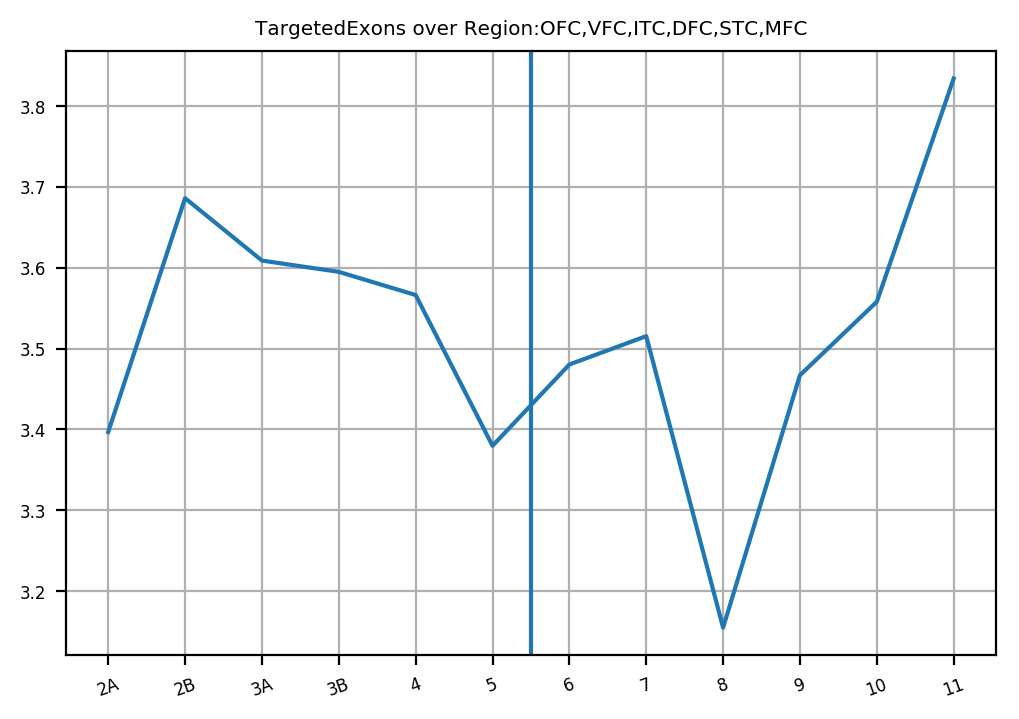

In [45]:
LookALLMutationTargetedGenes(Regions, GeneRow_withVar, GeneCol, GeneExp, smooth=False)

1
3
14
15
Three 0 data at stage 15


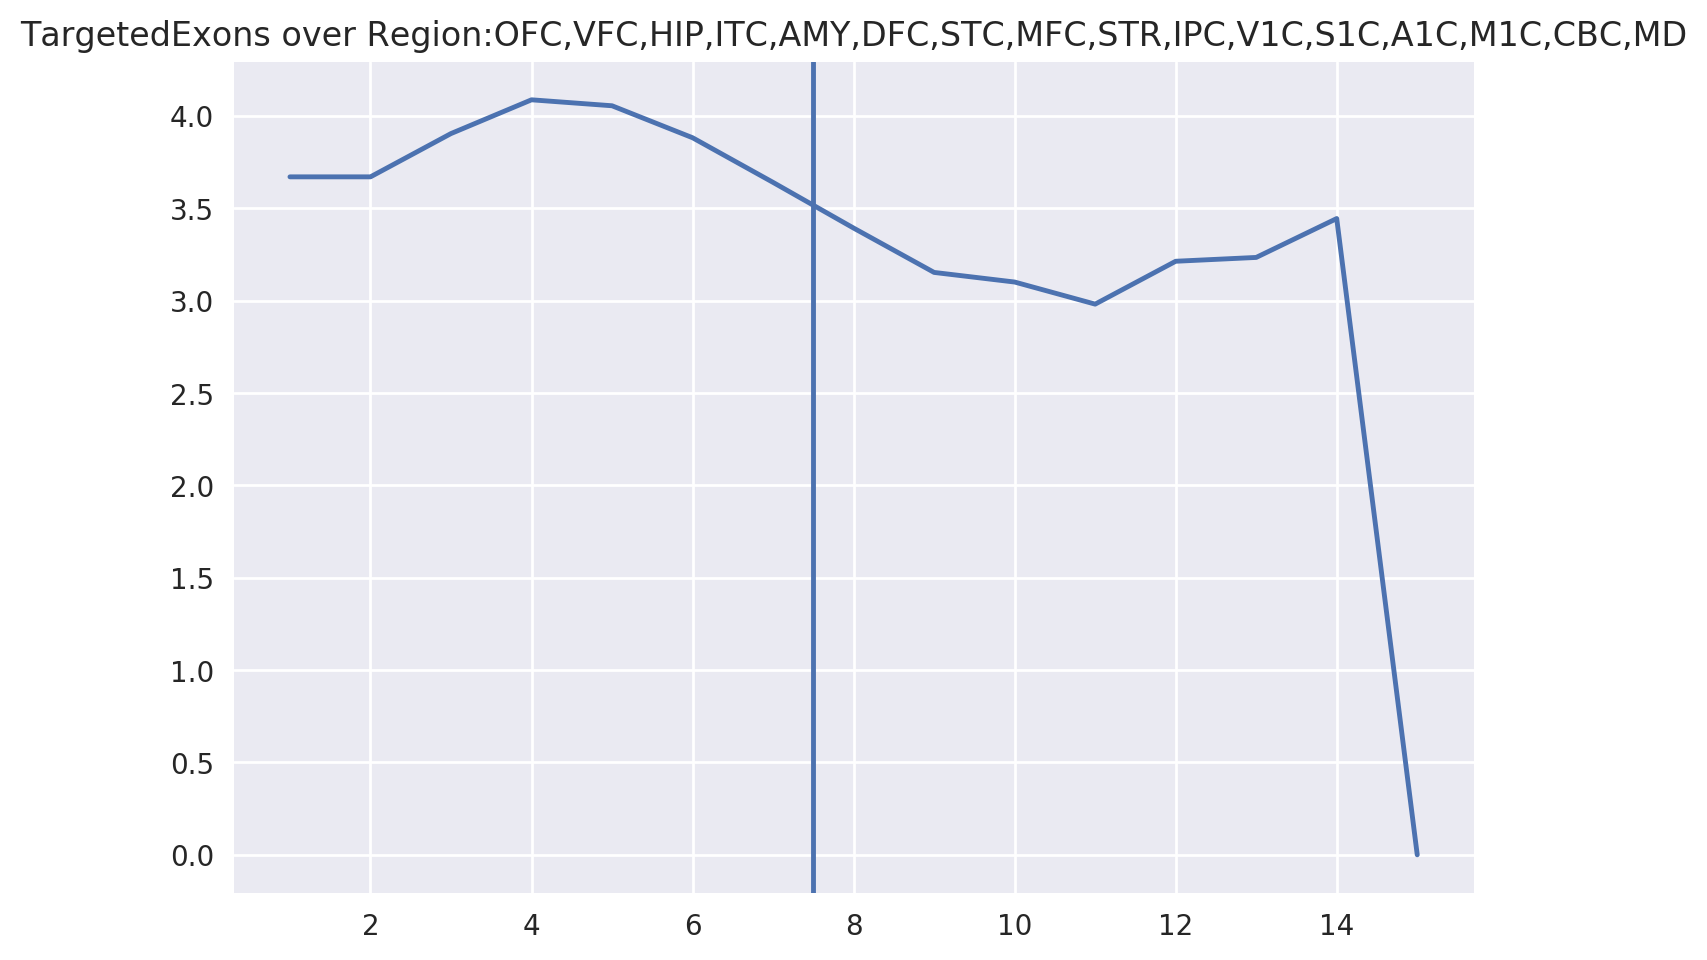

1
2
8
9
14
15
Three 0 data at stage 1
Three 0 data at stage 15


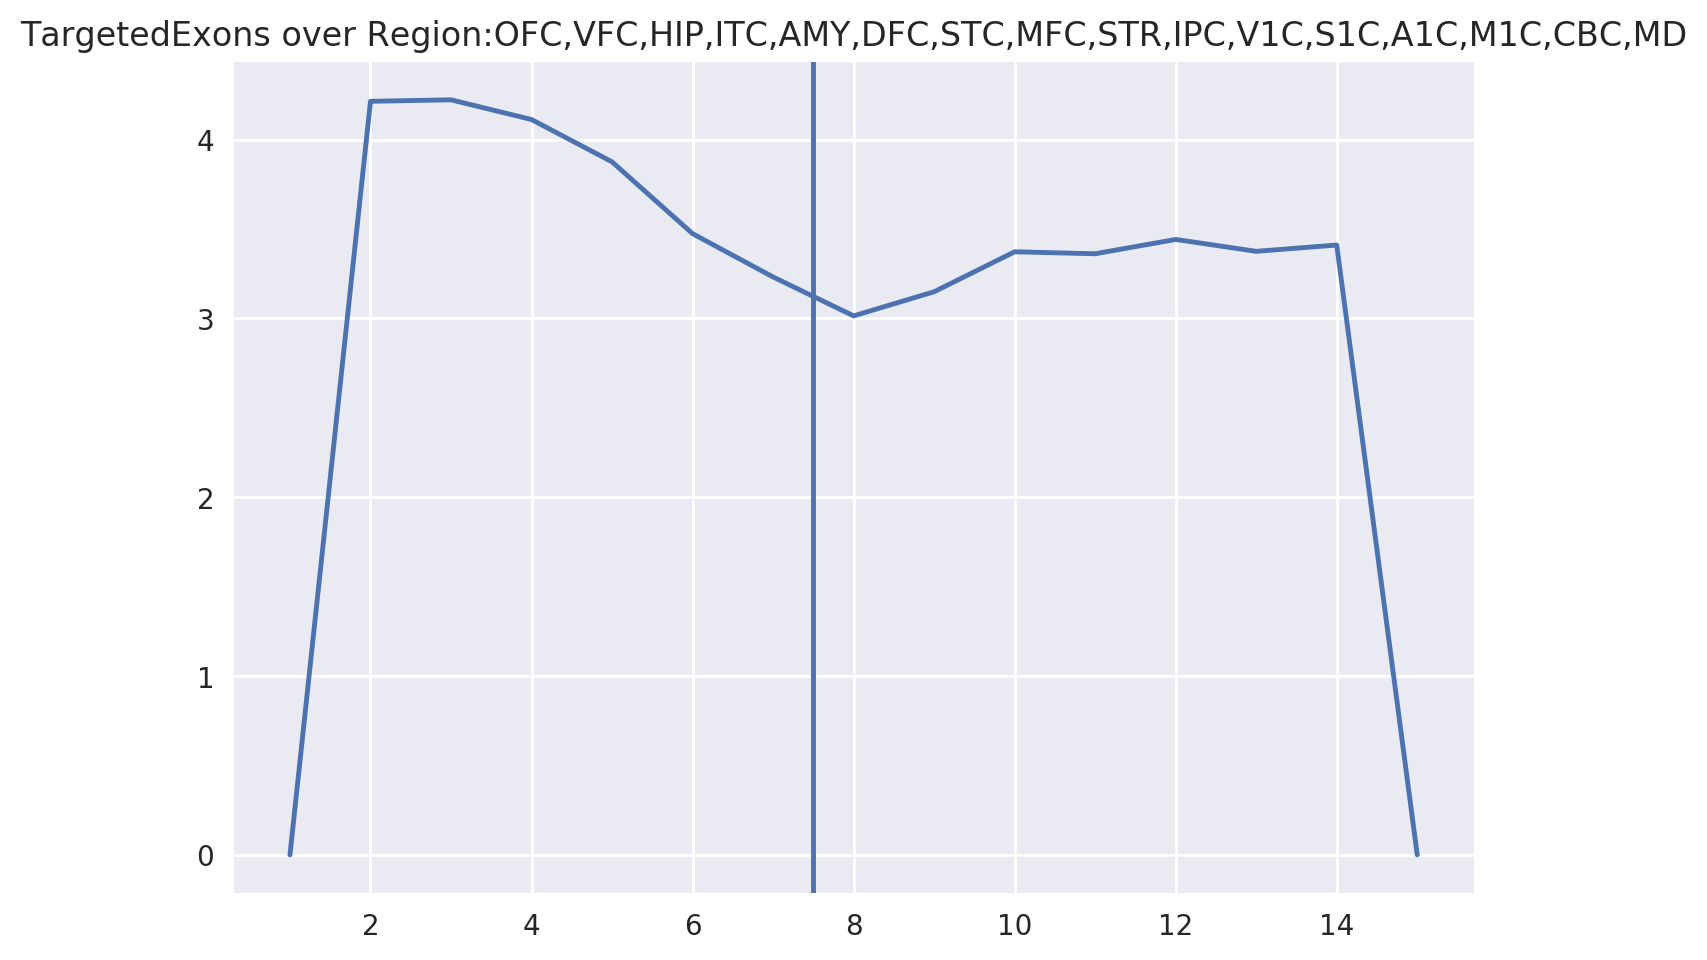

In [249]:
M_bp_gene_col_meta = GeneCol[GeneCol["gender"]=="M"]
F_bp_gene_col_meta = GeneCol[GeneCol["gender"]=="F"]
LookALLMutationTargetedGenes(rec_lgd_gene_symbols, Regionsgt20, (GeneExp, GeneRow, M_bp_gene_col_meta))
LookALLMutationTargetedGenes(rec_lgd_gene_symbols, Regionsgt20, (GeneExp, GeneRow, F_bp_gene_col_meta))